# 3D EFIT Rail Code in MPI

## Series model using Dieckman, Binggham, et. al. style

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import time
import functools

#from distBox import distBox

import sys
#from mpi4py import MPI
from os import environ 
from typing import *                     
import matplotlib.animation as animation

In [2]:
#MPIComm = Union[MPI.Intracomm, MPI.Intercomm]
#mpi_comm = MPI.COMM_WORLD
#myid = mpi_comm.Get_rank()                                                         
#mpi_size = mpi_comm.Get_size()        
nprocs=1 #mpi_size
myid = 0

# for overlapping slabs:  
# # points per proc along z = npz = gh1/nproc (+2 to ghost boundaries)
# glob_index = loc_index-1 + npz*myid
# loc_index = glob_index - npz*myid + 1
# myid given glob_index = glob_index/npz = ghloc-2

# set Constants
AirCut = False
RailShape = True
figDPI = 600

#Dimmesnsion of simulation space in meters
length1 = 2.5
width1 = 0.1524 # 0.1524
height1 = 0.1524
cycles = 20

#Image Folder
imFolder = '/sciclone/scr10/dchendrickson01/EFIT/'
runName = 'DoubleRub'

#is the rail supported by 0, 1 or 2 ties
Ties = 0
Flaw = False

#Choose ferquency to be used for excitment
frequency = 49720.0  #brute forced this number to be where simulation frequency 
#                     is 2,000,000, alowing for %10 to equal laser 200k same as actual
#            74574  is 3,000,000 hz running, and sample rate %15 is 200k same as actual, if we need more dense
Signalfrequency = 16300


#Run for 4 Cycles:
runtime = cycles / Signalfrequency 

#Forcing Function Location and type
# 1 for dropped wheel on top
# 2 for rubbing flange on side
# 3 for plane wave
FFunction = 6
Absorbers = 1

#MATERIAL 1 ((steel))
pRatio1 = 0.29                                    #poission's ratio in 
yModulus1 = 200 * (10**9)                           #youngs modulus in pascals
rho1 = 7800                                        #density in kg/m^3

#Image Folder
if FFunction == 1:
    imFolder += 'TopHit/'
elif FFunction == 2:
    imFolder += 'RailSide/'
elif FFunction ==3:
    imFolder += 'Cube/'
elif FFunction ==4:
    imFolder += 'Temp/'
elif FFunction == 5:
    imFolder += 'Double3m/'
elif FFunction == 6:   #long rail, two wheel rubs
    imFolder += 'AbsorbTest/'


WheelLoad = 173000 #crane force in Neutons

#CALCULATED PARAMETERS FROM INPUTS

mu1 = yModulus1/(2*(1+pRatio1))                    #second Lame Parameter
lmbda1 = 2 * mu1 * pRatio1 / (1 - 2 * pRatio1)     #first Lame Parameter

#Calculate speed of longitudinal and transverse waves in material 1
cl1 = np.sqrt((lmbda1 + 2* mu1)/rho1)
ct1 = np.sqrt(mu1/rho1)

#calculate wave lengths for material 1
omegaL1 = cl1 / frequency
omegaT1 = ct1 / frequency

In [3]:
#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
#ts = 1 / frequency / 10    #time step
gs = (min(omegaL1, omegaT1) /13)    #grid step
ts = gs/((max(cl1,ct1))*(np.sqrt(3)))*0.93 #time step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time Steps

#number of grid points
gl1 = int(math.ceil(length1 / gs)) +3       #length 
gw1 = int(math.ceil(width1 / gs)) +3      #width
gh1 = int(math.ceil(height1 / gs)) +3       #height

print(gs, ts, gl1, gw1, gh1, Tsteps)

0.004877343816768354 4.5178137402466586e-07 516 35 35 2717


In [4]:
# Keep these as the global values
xmax=gl1-1
ymax=gw1-1
zmax=gh1-1

In [5]:
## for latter rail section, define the dimmmensions in terms of grid
HeadThickness = 0.05
WebThickness = 0.035
FootThickness = 0.03
HeadWidth = 0.102

relHeadThick = HeadThickness / height1
relWeb = WebThickness / width1
relFoot = FootThickness / height1
relHeadWidth = HeadWidth / width1

relStartHeadThick = 1 - relHeadThick
relStartWeb = 0.5 - (relWeb / 2.0)
relEndWeb = 0.5 + (relWeb / 2.0)
relStartHeadWidth = 0.5 - (relHeadWidth / 2.0)
relEndHeadWidth = 0.5 + (relHeadWidth / 2.0)


gridStartHead = round((gh1-3) * relStartHeadThick) + 1
gridStartWeb = round((gw1-3) * relStartWeb)  + 1
gridEndWeb = round((gw1-3) * relEndWeb)  + 1
gridEndFoot = round((gh1-3) * relFoot)  + 1
gridStartHeadWidth = round((gw1-3) * relStartHeadWidth)  + 1
gridEndHeadWidth = round((gw1-3)  * relEndHeadWidth)  + 1



In [6]:
#####

#MPI EJW Section 1
#extend the length of the beam so that the number of nodes in the x dimmension 
#is the evenly divisible by the number of processors
if (gl1 % nprocs) != 0:
    gl1 += nprocs - (gl1 % nprocs)

#check you did it right
if (gl1 % nprocs) != 0:
    if myid == 0:
        print("Hey, gl1 not divisible by nproc",gl1,nprocs)
        sys.exit()
npx=int(gl1/nprocs)


if myid == 0:
    print("gl1,npx,nproc",gl1,npx,nprocs)

#print(runtime, ts, gs, Tsteps, gl, gh)

if myid == 0:
    print('runtime (s), time step size (s), total # of time steps:', runtime, ts, Tsteps)
    print('grid step size, # of length pts, # of height pts, # of width pts, gl1 loc pts:', gs,gl1,gw1,gh1,npx)

#tensor to store material properties for each point
#0 index is density
#1 index is first Lame Parmaeter
#2 index is second lame parameter

#MPI EJW Section 2 changes
matDensity=np.zeros((gl1,gw1,gh1))
matLambda=np.zeros((gl1,gw1,gh1))
matMu=np.zeros((gl1,gw1,gh1))
matBCs=np.zeros((gl1,gw1,gh1))
signalLocation=np.zeros((gl1,gw1,gh1))
AbsorbMatrix=np.ones((gl1,gw1,gh1))

matDensity[:,:,:]=rho1
matLambda[:,:,:]=lmbda1
matMu[:,:,:]=mu1
matBCs[:,:,:]=0

#Make the Signal Location grid
if FFunction == 1:
    pnodes = max(int(whlayer / 2),3)
    contactLength = max(int(0.001 / gs),3)  #1 cm contact patch or 3 nodes, whichever is larger
    
    #starting at .25 down, to be between the first 2 ties
    WheelStartPoint = int(0.25 * gl1)
    
    signalLocation[WheelStartPoint:WheelStartPoint+contactLength,gridStartHeadWidth:gridEndHeadWidth, -3:] = 1
    
elif FFunction == 2:
     
    signalLocation[14:20,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 1

    signalLocation[20,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 0.5
    signalLocation[13,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 0.5
    signalLocation[14:20,gridStartHeadWidth+2:gridStartHeadWidth+3,gridStartHead:zmax-2] = 0.5
    
elif FFunction == 3:
    signalLocation[2:4,:,:] = 1


elif FFunction == 4:
    start = 2*int(gh1/5)
    end = 3 * int(gh1/5)
    signalLocation[2:4,start:end,start:end] = 1

elif FFunction == 5:

    signalLocation[int(gl1/2)-5:int(gl1/2)+5,int(gw1/2)-5:int(gw1/2)+5,zmax-2] = 1
    signalLocation[int(gl1/2)-5:int(gl1/2)+5,int(gw1/2)-5:int(gw1/2)+5,zmax-1] = 0.5
    signalLocation[int(gl1/2)-5:int(gl1/2)+5,int(gw1/2)-5:int(gw1/2)+5,zmax-3] = 0.5
    

elif FFunction == 6:
     
    signalLocation[14:20,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 1

    signalLocation[20,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 0.5
    signalLocation[13,gridStartHeadWidth:gridStartHeadWidth+2,gridStartHead:zmax-2] = 0.5
    signalLocation[14:20,gridStartHeadWidth+2:gridStartHeadWidth+3,gridStartHead:zmax-2] = 0.5

    sep = int(1.360/gs)
    
    signalLocation[14+sep:20+sep,gridEndHeadWidth-2:gridEndHeadWidth,gridStartHead:zmax-2] = 1

    signalLocation[20+sep,gridEndHeadWidth-2:gridEndHeadWidth,gridStartHead:zmax-2] = 0.5
    signalLocation[13+sep,gridEndHeadWidth-2:gridEndHeadWidth,gridStartHead:zmax-2] = 0.5
    signalLocation[14+sep:20+sep,gridEndHeadWidth-3:gridEndHeadWidth-2,gridStartHead:zmax-2] = 0.5
    

specificWheelLoad = WheelLoad / np.sum(signalLocation)

gl1,npx,nproc 516 516 1
runtime (s), time step size (s), total # of time steps: 0.001226993865030675 4.5178137402466586e-07 2717
grid step size, # of length pts, # of height pts, # of width pts, gl1 loc pts: 0.004877343816768354 516 35 35 516


In [7]:
if Absorbers >= 1:
    for i in range(12):
        AbsorbMatrix[i,:,:]=i/13
if Absorbers == 2:
    for i in range(12):
        AbsorbMatrix[xmax-i,:,:]=i/13
    
    
if myid == 0:
    print('globs made, line 145')

globs made, line 145


In [8]:
#########
# FUnctions
def JBSU(x,y,z):
    try:
        if (matBCs[x,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y-1,z] == 2 or matBCs[x,y,z-1] == 2):
            pass
        else:
            norm1=(1/gs)*(matLambda[x,y,z]+2*matMu[x,y,z])
            norm2=(1/gs)*(matLambda[x,y,z])

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

        if (matBCs[x,y,z] == 2 or matBCs[x+1,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y+1,z] == 2 
            or matBCs[x,y-1,z] == 2 or matBCs[x,y,z-1] == 2 or matBCs[x+1,y+1,z] == 2):
            pass
        else:
            shearDenomxy=(1/matMu[x,y,z])+(1/matMu[x+1,y,z])+(1/matMu[x,y+1,z])+(1/matMu[x+1,y+1,z])
            shearxy=4*(1/gs)*(1/shearDenomxy)
            ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
            sxy[x,y,z]=sxy[x,y,z]+ds*ts

        if (matBCs[x,y,z] == 2 or matBCs[x+1,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y,z+1] == 2 
            or matBCs[x,y,z-1] == 2 or matBCs[x,y-1,z] == 2 or matBCs[x+1,y,z+1] == 2):
            pass
        else:
            shearDenomxz=(1/matMu[x,y,z])+(1/matMu[x+1,y,z])+(1/matMu[x,y,z+1])+(1/matMu[x+1,y,z+1])
            shearxz=4*(1/gs)*(1/shearDenomxz)
            ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
            sxz[x,y,z]=sxz[x,y,z]+ds*ts   

        if (matBCs[x,y,z] == 2 or matBCs[x,y,z+1] == 2 or matBCs[x,y,z-1] == 2 or matBCs[x,y+1,z] == 2 
            or matBCs[x,y-1,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y+1,z+1] == 2):
            pass
        else:
            shearDenomyz=(1/matMu[x,y,z])+(1/matMu[x,y+1,z])+(1/matMu[x,y,z+1])+(1/matMu[x,y+1,z+1])
            shearyz=4*(1/gs)*(1/shearDenomyz)
            ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
            syz[x,y,z]=syz[x,y,z]+ds*ts
    except:
        print('Unrecognized BC stress', matBCs[x,y,z],x,y,z)


In [9]:
# %%
def JBUV(x,y,z):
    
    if matBCs[x,y,z] == 0: 
        dvxConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x+1,y,z]))
        dv=dvxConst*( sxx[x+1,y,z]-sxx[x,y,z]
                     +sxy[x,y,z]-sxy[x,y-1,z]
                     +sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts
    #x at 0
    elif (matBCs[x,y,z] ==2 or matBCs[x,y-1,z]==2 or matBCs[x,y,z-2]==2):
        pass #requires elements out of the direction
    elif matBCs[x+1,y,z] == 2:
        vx[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((-2)*sxx[x,y,z])

    elif matBCs[x-1,y,z] ==2 :
        vx[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((2)*sxx[x+1,y,z])

    else:
        dvxConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x+1,y,z]))
        dv=dvxConst*( sxx[x+1,y,z]-sxx[x,y,z]
                     +sxy[x,y,z]-sxy[x,y-1,z]
                     +sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts
    
    #Vy cases
    if matBCs[x,y,z] == 0: 
        dvyConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y+1,z]))
        dv=dvyConst* ( sxy[x,y,z]-sxy[x-1,y,z]
                      +syy[x,y+1,z]-syy[x,y,z]
                      +syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts
    #y = 0
    elif (matBCs[x,y,z] ==2 or matBCs[x-1,y,z] == 2 or matBCs[x,y,z-1] == 2):
        pass  #requires elements out of the direction
    elif matBCs[x,y+1,z] == 2:
        vy[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((-2)*syy[x,y,z])
    elif matBCs[x,y-1,z] == 2:
        vy[x,y,z] += 2 * ts/gs * 1/(2 * matDensity[x,y,z]) * ((2)*syy[x,y+1,z])
    else:
        dvyConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y+1,z]))
        dv=dvyConst* ( sxy[x,y,z]-sxy[x-1,y,z]
                      +syy[x,y+1,z]-syy[x,y,z]
                      +syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

    #Vz cases
    if matBCs[x,y,z] ==0:
        dvzConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y,z+1]))
        dv=dvzConst*( sxz[x,y,z]-sxz[x-1,y,z]
                     +syz[x,y,z]-syz[x,y-1,z]
                     +szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts
    #z at 0
    elif (matBCs[x,y,z] == 2 or matBCs[x-1,y,z] == 2 or matBCs[x,y-1,z]==2):
        pass
    elif matBCs[x,y,z+1] == 2:
        vz[x,y,z] += 2 * ts/gs *(1/(2 * matDensity[x,y,z])) * ((-2)*szz[x,y,z])
    elif matBCs[z,y,z-1] == 2:
        vz[x,y,z] += 2 * ts/gs *(1/(2 * matDensity[x,y,z])) * ((2)*szz[x,y,z+1])
    else:
        dvzConst=2*(1/gs)*(1/(matDensity[x,y,z]+matDensity[x,y,z+1]))
        dv=dvzConst*( sxz[x,y,z]-sxz[x-1,y,z]
                     +syz[x,y,z]-syz[x,y-1,z]
                     +szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


In [10]:
def setSimSpaceBC99(matBCs):
    
    matBCs[0,:,:]=99
    matBCs[xmax,:,:]=99
    matBCs[:,0,:]=99
    matBCs[:,ymax,:]=99
    matBCs[:,:,0]=99
    matBCs[:,:,zmax]=99
    
    return matBCs


In [11]:
def setSimSpaceBCs(matBCs):
    #Second Dimmension boundaries /y
    matBCs[:,0,:]=2
    matBCs[:,1,:]=1
    matBCs[:,ymax,:]=2
    matBCs[:,ymax-1,:]=2
    matBCs[:,ymax-2,:]=1

    #Third Dimmension Boundaries /z
    matBCs[:,:,0]=2
    matBCs[:,2:ymax-1,1]=1
    matBCs[:,:,zmax]=2
    matBCs[:,:,zmax-1]=2
    matBCs[:,2:ymax-1,zmax-2]=1
    
    #First Dimmension Boundaries /x
    #   handled different if this is going to be calculated by node
    #   others c does it different, but they split between nodes before calculating
    #   here we calculate the whole set and then parse
    matBCs[0,:,:]=2
    matBCs[1,2:ymax-1,1:zmax-1]=1
    matBCs[xmax,:,:]=2
    matBCs[xmax-1,:,:]=2
    matBCs[xmax-2,1:ymax-1,1:zmax-1]=1
    
    return matBCs
    

In [12]:
def MakeFlaw(matBCs, Type=1):
    #Type 1 is a chunck missing in the middle halfway from the center input to the end
    
    if Type==1:
        MidPoint = int(gl1/2)
        StartTrans = int(gl1/5)*2
        EndTrans = int(gl1/5)*3

        TransToEnd = gl1-EndTrans
        MidTransToEnd = int(TransToEnd/2)+EndTrans
        QuarterTrans = int((EndTrans-StartTrans)/4)

        StartFlawX = MidTransToEnd - QuarterTrans
        EndFlawX = MidTransToEnd + QuarterTrans

        StartFlawY = MidPoint - QuarterTrans
        EndFlawY = MidPoint + QuarterTrans

        VertFlaw = int(gh1/8)
        VertStart = zmax - VertFlaw

        #main hole
        matBCs[StartFlawX:EndFlawX,StartFlawY:EndFlawY,VertStart:] = 2

        #edges
        matBCs[StartFlawX:EndFlawX,StartFlawY:EndFlawY,VertStart-1] = 1
        matBCs[StartFlawX-1,StartFlawY-1:EndFlawY+1,VertStart:zmax-2]=1
        matBCs[EndFlawX+1,StartFlawY-1:EndFlawY+1,VertStart:zmax-2]=1
        matBCs[StartFlawX-1:EndFlawX+1,StartFlawY-1,VertStart:zmax-2]=1
        matBCs[StartFlawX-1:EndFlawX+1,EndFlawY+1,VertStart:zmax-2]=1
    
    return matBCs
    

In [13]:
def setRailBCs(matBCs):
    #top of foot
    matBCs[:,1:gridStartWeb,gridEndFoot]=1
    matBCs[:,gridEndWeb:ymax-1,gridEndFoot]=1

    #Sides Web
    matBCs[:,gridStartWeb,gridEndFoot:gridStartHead] = 1
    matBCs[:,gridEndWeb,gridEndFoot:gridStartHead] =1

    #bottom Head
    matBCs[:,gridStartHeadWidth:gridStartWeb+1,gridStartHead] = 1
    matBCs[:,gridEndWeb:gridEndHeadWidth,gridStartHead] = 1

    #Sides HEad
    matBCs[:,gridStartHeadWidth,gridStartHead:zmax-1] = 1
    matBCs[:,gridEndHeadWidth,gridStartHead:zmax-1] = 1

    #air beside Web
    matBCs[:,1:gridStartWeb,gridEndFoot+1:gridStartHead] = 2
    matBCs[:,gridEndWeb+1:ymax,gridEndFoot+1:gridStartHead] = 2

    #air beside head
    matBCs[:,1:gridStartHeadWidth,gridStartHead:zmax] = 2
    matBCs[:,gridEndHeadWidth+1:ymax,gridStartHead:zmax] = 2

    
    return matBCs

In [14]:
#matBCs = setSimSpaceBC99(matBCs)
matBCs = setSimSpaceBCs(matBCs)
    

In [15]:
if RailShape:
    #matDensity,matLambda,matMu = setAirCut(matDensity,matLambda,matMu)
    matBCs = setRailBCs(matBCs)
    #matBCs = addTies(matBCs,Ties)

#Add Flaw
#    136 x 136 x15
if Flaw:
    matBCs = MakeFlaw(matBCs)

In [16]:
np.savetxt("BCs.csv",matBCs[9,:,:].T,delimiter=",")

air cuts made, line 310
line 369: glb inputx, local inputx id, local inputx:   2 0 3


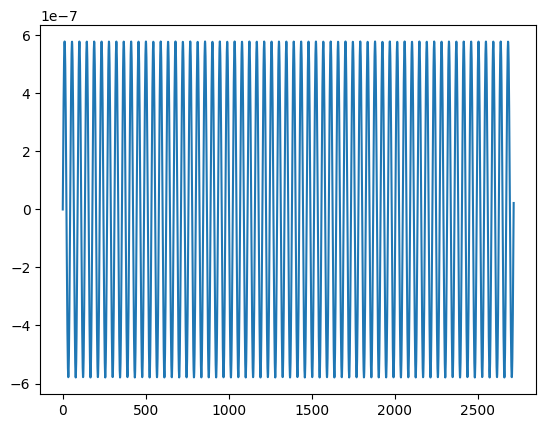

In [17]:
if myid == 0:
    print('air cuts made, line 310')

#define sine-exponential wave excitation

timeVec=np.linspace(0,runtime,Tsteps)

#MPI EJW Section #3 changes
#radius
r=3
inputx=2
inputy=int(gw1/2)
inputz=int(gh1/2)

# get loc by formula

inputid=int(inputx / npx)
inputlocx=int(inputx - inputid*npx+1)

if (myid == 0) :
    print("line 369: glb inputx, local inputx id, local inputx:  ",inputx,inputid,inputlocx)


szzConst=2*ts/(gs*rho1)

amp=10000
decayRate= 0
sinConst=ts*amp/rho1

sinInputSignal=sinConst*np.sin(2*np.pi*frequency*timeVec)*np.exp(-decayRate*timeVec)
#sinInputSignal-=0.0000001
#sinInputSignal[int(1/12*Tsteps):]=0

fig = plt.figure()
plt.plot(sinInputSignal)
plt.show()

In [18]:
# MPI EJW Section #4 changes 

#initialize fields
vx=np.zeros((npx,gw1,gh1))
vy=np.zeros((npx,gw1,gh1))
vz=np.zeros((npx,gw1,gh1))

sxx=np.zeros((npx,gw1,gh1))
syy=np.zeros((npx,gw1,gh1))
szz=np.zeros((npx,gw1,gh1))
sxy=np.zeros((npx,gw1,gh1))
sxz=np.zeros((npx,gw1,gh1))
syz=np.zeros((npx,gw1,gh1))

#record the signal at a specified location
### ADD map function for this
signalLocx=int(gl1/2)
signalLocy=int(gw1/2)
signalLocz=int(gh1/2)

vxSignal=np.zeros(Tsteps)
vySignal=np.zeros(Tsteps)
vzSignal=np.zeros(Tsteps)

In [19]:

#record the signal at a specified location
### ADD map function for this
#SAME AS INPUTZ?

#manually setting x for long where wave may not propaagate full lengthh in time

## All signals at 4 nodes from end
FromEnd = 50
# Top of rail
FSignalLocX= gl1-FromEnd
FSignalLocY=int(gw1/2)
FSignalLocZ=gh1-4

## End halfway up head
BSignalLocX=gl1-FromEnd
BSignalLocY=int(gw1/2)
BSignalLocZ=int((gh1-gridStartHead)/2+gridStartHead)

## left of head
USignalLocX=gl1-FromEnd
USignalLocY=gridStartHeadWidth+1
USignalLocZ=int((gh1-gridStartHead)/2+gridStartHead)

## right of head
DSignalLocX=gl1-FromEnd
DSignalLocY=gridEndHeadWidth-1
DSignalLocZ=int((gh1-gridStartHead)/2+gridStartHead)

## right of web
RSignalLocX=gl1-FromEnd
RSignalLocY=gridStartWeb+1
RSignalLocZ=int((gridStartHead-gridEndFoot)/2+gridEndFoot)

## Left of Web
LSignalLocX=gl1-FromEnd
LSignalLocY=gridEndWeb-1
LSignalLocZ=int((gridStartHead-gridEndFoot)/2+gridEndFoot)

## End of Web
MSignalLocX=gl1-FromEnd
MSignalLocY=int(gw1/2)
MSignalLocZ=int((gridStartHead-gridEndFoot)/2+gridEndFoot)


#signal locations going to be a quarter of the way in the middle from the 
# Front, Back, Up side, Down side, Right, Left, and Middle Middle Middle
FSignal=np.zeros((Tsteps,3))
BSignal=np.zeros((Tsteps,3))
USignal=np.zeros((Tsteps,3))
DSignal=np.zeros((Tsteps,3))
RSignal=np.zeros((Tsteps,3))
LSignal=np.zeros((Tsteps,3))
MSignal=np.zeros((Tsteps,3))

In [20]:
signalloc = np.zeros((npx,gw1,gh1))
signalloc=signalLocation[:,:,:]

stime = time.time()

In [21]:
# asdfasdf
MidMatrixX = np.zeros((gl1,Tsteps))
MidMatrixY = np.zeros((gl1,Tsteps))
MidMatrixZ = np.zeros((gl1,Tsteps))

Movements = np.zeros((gl1,gw1,gh1,Tsteps))
DisX = np.zeros((gl1,gw1,gh1))
DisY = np.zeros((gl1,gw1,gh1))
DisZ = np.zeros((gl1,gw1,gh1))


In [22]:
writeFile = open(imFolder + 'LaserPoints.csv','a')
writeFile.write('Time,topX, topY, topZ, endX, endY, endZ, rHeadX, rHeadY, rHeadZ, lHeadX, lHeadY, lHeadZ, rWebX, rWebY, rWebZ, lWebX, lWebY, lWebZ')
AnimationData =  open(imFolder + 'Anima.csv','a')
AnimationData.write("time,x,y,z,Energy\n")

18

In [23]:
for t in range(Tsteps):
     
    if FFunction == 2:
        vz += signalloc * sinInputSignal[t]
        #print(np.sum(vz))
    
    if FFunction == 3:
        vx += signalloc * sinInputSignal[t]

    if FFunction == 4 or  FFunction == 5 or  FFunction == 6:
        vz += signalloc * sinInputSignal[t]

    for x in range(0,xmax):
        for y in range(0,ymax):
            for z in range(0,zmax):
                JBSU(x,y,z)
                if matBCs[x,y,z]==1:
                    AnimationData.write(str(t)+","+str(x)+","+str(y)+","+str(z)+","
                                        +str(np.sqrt(vx[x,y,z]**2+vy[x,y,z]**2+vz[x,y,z]**2))
                                        +"\n")
    vx *= AbsorbMatrix
    #vy *= AbsorbMatrix
    #vz *= AbsorbMatrix
    
    # cut boundaries off of arrays
    '''Remove for Jupyter single processor
    sxxt=sxx[1:npx+1,:,:]
    syyt=syy[1:npx+1,:,:]
    szzt=szz[1:npx+1,:,:]
    sxyt=sxy[1:npx+1,:,:]
    sxzt=sxz[1:npx+1,:,:]
    syzt=syz[1:npx+1,:,:]

    # redistrubute ghost/boundary values
    sxx=distBox(sxxt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    syy=distBox(syyt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    szz=distBox(szzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    sxy=distBox(sxyt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    sxz=distBox(sxzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    syz=distBox(syzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    '''
    
    #if the forcing function is a stress
    if FFunction == 1:
        szz -= signalloc * specificWheelLoad

    for x in range(0,xmax):
        for y in range(0,ymax):
            for z in range(0,zmax):
                JBUV(x,y,z)

    MidMatrixX[:,t] = vx[:,MSignalLocY,MSignalLocZ]
    MidMatrixY[:,t] = vy[:,MSignalLocY,MSignalLocZ]
    MidMatrixZ[:,t] = vz[:,MSignalLocY,MSignalLocZ]
    
    vxg=vx #[1:npx+1,:,:]        
    vyg=vy#[1:npx+1,:,:]        
    vzg=vz#[1:npx+1,:,:]        

    
    if (myid == 0 ) :
        USignal[t]=[vxg[USignalLocX,USignalLocY,USignalLocZ],vyg[USignalLocX,USignalLocY,USignalLocZ],vzg[USignalLocX,USignalLocY,USignalLocZ]]
        DSignal[t]=[vxg[DSignalLocX,DSignalLocY,DSignalLocZ],vyg[DSignalLocX,DSignalLocY,DSignalLocZ],vzg[DSignalLocX,DSignalLocY,DSignalLocZ]]
        RSignal[t]=[vxg[RSignalLocX,RSignalLocY,RSignalLocZ],vyg[RSignalLocX,RSignalLocY,RSignalLocZ],vzg[RSignalLocX,RSignalLocY,RSignalLocZ]]
        LSignal[t]=[vxg[LSignalLocX,LSignalLocY,LSignalLocZ],vyg[LSignalLocX,LSignalLocY,LSignalLocZ],vzg[LSignalLocX,LSignalLocY,LSignalLocZ]]
        MSignal[t]=[vxg[MSignalLocX,MSignalLocY,MSignalLocZ],vyg[MSignalLocX,MSignalLocY,MSignalLocZ],vzg[MSignalLocX,MSignalLocY,MSignalLocZ]]
        FSignal[t]=[vxg[FSignalLocX,FSignalLocY,FSignalLocZ],vyg[FSignalLocX,FSignalLocY,FSignalLocZ],vzg[FSignalLocX,FSignalLocY,FSignalLocZ]]
        BSignal[t]=[vxg[BSignalLocX,BSignalLocY,BSignalLocZ],vyg[BSignalLocX,BSignalLocY,BSignalLocZ],vzg[BSignalLocX,BSignalLocY,BSignalLocZ]]
        
        DisX += vx[:,:,:] * ts
        DisY += vy[:,:,:] * ts
        DisZ += vz[:,:,:] * ts
        Movements[:,:,:,t] = np.sqrt(DisX**2 + DisY**2 + DisZ**2)
        writeFile.write(str(t)+','
                 +str(FSignal[-1][0])+','+str(FSignal[-1][1])+','+str(FSignal[-1][2])+','
                 +str(BSignal[-1][0])+','+str(BSignal[-1][1])+','+str(BSignal[-1][2])+','
                 +str(USignal[-1][0])+','+str(USignal[-1][1])+','+str(USignal[-1][2])+','
                 +str(DSignal[-1][0])+','+str(DSignal[-1][1])+','+str(DSignal[-1][2])+','
                 +str(RSignal[-1][0])+','+str(RSignal[-1][1])+','+str(RSignal[-1][2])+','
                 +str(LSignal[-1][0])+','+str(LSignal[-1][1])+','+str(LSignal[-1][2])+','
                 +str(MSignal[-1][0])+','+str(MSignal[-1][1])+','+str(MSignal[-1][2])+'\n'
                )
        if t%5==0:
        
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,:,int(gh1/2)]), cmap='seismic')
            plt.savefig(imFolder+'Mid/vyMidHeightShear'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,int(gw1/2),:]), cmap='seismic')
            plt.savefig(imFolder + 'Vert/vyVertShear'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)    
            
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[int(gl1/2),:,:]), cmap='seismic')
            plt.savefig(imFolder + 'Head/vyMidLenShear'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)  
    
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,:,int(gh1/4)]), cmap='seismic')
            plt.savefig(imFolder+'zplane25/vy25Shear'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,:,int(3*gh1/4)]), cmap='seismic')
            plt.savefig(imFolder+'zplane75/vy75Shear'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(Movements[:,:,zmax-1,t]), cmap='seismic')
            plt.savefig(imFolder+'TopSurface/TopSurface'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(Movements[3:,ymax,:,t]), cmap='seismic')
            plt.savefig(imFolder+'RightSurface/RightSurface'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(Movements[3:,0,:,t]), cmap='seismic')
            plt.savefig(imFolder+'LeftSurface/LeftSurface'+str(t).zfill(8)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            

    # Collect vx, sxx checksum contributions for printing
    vxt=vx[1:npx+1,:,:]
    sxxt=sxx[1:npx+1,:,:]

    #ckvs=np.array(0.0,'d')
    #ckss=np.array(0.0,'d')
    
    ckv=np.sum(np.absolute(vxg))
    cks=np.sum(np.absolute(sxx))
    #mpi_comm.Reduce(ckv,ckvs,op=MPI.SUM,root=0)
    #mpi_comm.Reduce(cks,ckss,op=MPI.SUM,root=0)

    if (myid == 0 ):
        print(t,'/',Tsteps-1,'check vx, sxx:',ckv,cks, int(((time.time()-stime)/60.0)*100)/100)
    sys.stdout.flush()

0 / 2716 check vx, sxx: 0.0 0.0 0.24
1 / 2716 check vx, sxx: 1.879097376798e-07 21.812847576653052 0.41
2 / 2716 check vx, sxx: 8.802110889230041e-07 79.41737338262823 0.58
3 / 2716 check vx, sxx: 2.45451708795538e-06 176.32360050332824 0.75
4 / 2716 check vx, sxx: 5.330481328383205e-06 311.1253915529788 0.92
5 / 2716 check vx, sxx: 9.967118091964994e-06 488.3414172281843 1.11
6 / 2716 check vx, sxx: 1.6834594590294147e-05 743.8128236034061 1.28
7 / 2716 check vx, sxx: 2.6365475006946316e-05 1092.0054385336073 1.46
8 / 2716 check vx, sxx: 3.890795882504801e-05 1570.4693594086648 1.63
9 / 2716 check vx, sxx: 5.463498729135764e-05 2190.679952389288 1.81
10 / 2716 check vx, sxx: 7.355349356595539e-05 2961.118044239345 2.0
11 / 2716 check vx, sxx: 9.555048719757795e-05 3877.563645319506 2.18
12 / 2716 check vx, sxx: 0.00012045102756790015 4916.550313555555 2.35
13 / 2716 check vx, sxx: 0.00014796821317957068 6122.790494250154 2.52
14 / 2716 check vx, sxx: 0.00017776578396264228 7467.976383

117 / 2716 check vx, sxx: 0.006060866248943761 228717.70260920658 20.87
118 / 2716 check vx, sxx: 0.006146727977467037 231325.04063001028 21.05
119 / 2716 check vx, sxx: 0.006223944188262667 234064.38451568966 21.22
120 / 2716 check vx, sxx: 0.006292920773576127 236742.4293934143 21.42
121 / 2716 check vx, sxx: 0.006348090412158364 239429.70964353482 21.59
122 / 2716 check vx, sxx: 0.006391459286595127 242146.60116301625 21.76
123 / 2716 check vx, sxx: 0.006420473364897635 244641.370546257 21.94
124 / 2716 check vx, sxx: 0.006438703657425358 246771.97680028202 22.11
125 / 2716 check vx, sxx: 0.006454963082941363 248885.14133949162 22.3
126 / 2716 check vx, sxx: 0.006468459167605723 250666.7260337873 22.48
127 / 2716 check vx, sxx: 0.0064885288272394865 252204.66596242593 22.65
128 / 2716 check vx, sxx: 0.006516085696100501 253637.10652353332 22.82
129 / 2716 check vx, sxx: 0.0065518771244704194 254695.42166772345 22.99
130 / 2716 check vx, sxx: 0.006598245088759769 255791.60745838375 2

234 / 2716 check vx, sxx: 8.33543992899133 255789292.32221454 41.69
235 / 2716 check vx, sxx: 9.59745557466172 294513028.60608107 41.88
236 / 2716 check vx, sxx: 11.050847660684665 339109083.1195005 42.05
237 / 2716 check vx, sxx: 12.724645930919191 390467913.07453775 42.23
238 / 2716 check vx, sxx: 14.65227411141215 449615064.89615047 42.4
239 / 2716 check vx, sxx: 16.872227173850856 517731298.12422085 42.58
240 / 2716 check vx, sxx: 19.42883387852614 596176993.3664547 42.77
241 / 2716 check vx, sxx: 22.373132055954983 686518085.1888772 42.94
242 / 2716 check vx, sxx: 25.763894326692114 790558085.1293962 43.12
243 / 2716 check vx, sxx: 29.668810395898195 910374395.8239579 43.32
244 / 2716 check vx, sxx: 34.16581732178483 1048359432.3819754 43.49
245 / 2716 check vx, sxx: 39.34469322444006 1207267282.0434895 43.68
246 / 2716 check vx, sxx: 45.30881592422255 1390270072.9305792 43.85
247 / 2716 check vx, sxx: 52.17724853562286 1601021439.7771134 44.03
248 / 2716 check vx, sxx: 60.0870925

354 / 2716 check vx, sxx: 188783097.8972555 5792852329173952.0 63.53
355 / 2716 check vx, sxx: 217392882.94154838 6670751308723024.0 63.72
356 / 2716 check vx, sxx: 250338355.12492514 7681692183442236.0 63.89
357 / 2716 check vx, sxx: 288276557.7144748 8845836550652026.0 64.07
358 / 2716 check vx, sxx: 331964102.81718034 1.0186401314598658e+16 65.1
359 / 2716 check vx, sxx: 382272259.9138881 1.1730121684145424e+16 65.27
360 / 2716 check vx, sxx: 440204330.8626401 1.3507784331747824e+16 66.33
361 / 2716 check vx, sxx: 506915657.8519551 1.555484134562191e+16 66.5
362 / 2716 check vx, sxx: 583736663.2881702 1.7912117218109956e+16 66.67
363 / 2716 check vx, sxx: 672199381.0605958 2.0626622968483212e+16 66.85
364 / 2716 check vx, sxx: 774068008.2490892 2.375249363477171e+16 67.4
365 / 2716 check vx, sxx: 891374086.5097396 2.7352067829294636e+16 68.04
366 / 2716 check vx, sxx: 1026457014.6935549 3.1497130885419332e+16 68.24
367 / 2716 check vx, sxx: 1182010700.5617898 3.62703463852246e+16 68

467 / 2716 check vx, sxx: 1585921088458984.8 4.866485671736051e+22 86.54
468 / 2716 check vx, sxx: 1826230667306299.5 5.603888979740705e+22 86.72
469 / 2716 check vx, sxx: 2102953448357522.5 6.453028252511031e+22 86.89
470 / 2716 check vx, sxx: 2421606966976051.0 7.430834362392256e+22 87.08
471 / 2716 check vx, sxx: 2788544804193723.5 8.556803636132062e+22 87.26
472 / 2716 check vx, sxx: 3211083268341313.5 9.853386584848995e+22 87.44
473 / 2716 check vx, sxx: 3697647272035625.5 1.1346435536081285e+23 87.61
474 / 2716 check vx, sxx: 4257938313081241.0 1.3065720092998861e+23 87.79
475 / 2716 check vx, sxx: 4903127908560571.0 1.5045520698223303e+23 87.98
476 / 2716 check vx, sxx: 5646080338880169.0 1.7325312136977223e+23 88.16
477 / 2716 check vx, sxx: 6501609142932913.0 1.9950550607525107e+23 88.33
478 / 2716 check vx, sxx: 7486772478476217.0 2.297358005182611e+23 88.51
479 / 2716 check vx, sxx: 8621213236733366.0 2.6454675817167427e+23 88.69
480 / 2716 check vx, sxx: 9927550692548264.0 

575 / 2716 check vx, sxx: 6.573071348303988e+21 2.016987191490749e+29 106.06
576 / 2716 check vx, sxx: 7.569038758631836e+21 2.322605909256255e+29 106.24
577 / 2716 check vx, sxx: 8.715917387845382e+21 2.6745326641649907e+29 106.42
578 / 2716 check vx, sxx: 1.003657362474898e+22 3.0797841488372536e+29 106.59
579 / 2716 check vx, sxx: 1.1557338619562034e+22 3.5464402393791566e+29 106.77
580 / 2716 check vx, sxx: 1.3308533271235196e+22 4.083805090996639e+29 106.96
581 / 2716 check vx, sxx: 1.532507276180997e+22 4.702592643113983e+29 107.14
582 / 2716 check vx, sxx: 1.76471626909298e+22 5.415140232568086e+29 107.31
583 / 2716 check vx, sxx: 2.032110068991835e+22 6.235654573863563e+29 107.49
584 / 2716 check vx, sxx: 2.3400199497872774e+22 7.180495010802301e+29 107.67
585 / 2716 check vx, sxx: 2.694584990390745e+22 8.268499686911026e+29 107.86
586 / 2716 check vx, sxx: 3.1028744748308617e+22 9.521361137797434e+29 108.04
587 / 2716 check vx, sxx: 3.573028838652301e+22 1.096405879393066e+30 

689 / 2716 check vx, sxx: 6.350281067596383e+28 1.9486235647352775e+36 126.69
690 / 2716 check vx, sxx: 7.312484354832439e+28 2.2438816806939422e+36 126.93
691 / 2716 check vx, sxx: 8.420481976176496e+28 2.5838777033666933e+36 127.49
692 / 2716 check vx, sxx: 9.696364881351447e+28 2.9753903794325933e+36 127.67
693 / 2716 check vx, sxx: 1.116557126942607e+29 3.426225580066592e+36 127.85
694 / 2716 check vx, sxx: 1.2857393768310852e+29 3.9453719321562076e+36 128.03
695 / 2716 check vx, sxx: 1.480556346272985e+29 4.543180030956397e+36 128.23
696 / 2716 check vx, sxx: 1.7048922414845394e+29 5.2315688072714576e+36 128.4
697 / 2716 check vx, sxx: 1.9632198086052256e+29 6.024263163651688e+36 128.58
698 / 2716 check vx, sxx: 2.2606895100132893e+29 6.93706761752473e+36 128.76
699 / 2716 check vx, sxx: 2.6032322127482156e+29 7.98818140707696e+36 128.93
700 / 2716 check vx, sxx: 2.9976774364113005e+29 9.19856134237214e+36 129.17
701 / 2716 check vx, sxx: 3.4518895181356764e+29 1.0592339636124733e

795 / 2716 check vx, sxx: 1.984359077658329e+35 6.089130835633694e+42 153.35
796 / 2716 check vx, sxx: 2.2850314875862974e+35 7.011763069247882e+42 153.52
797 / 2716 check vx, sxx: 2.6312621311065385e+35 8.074193613387668e+42 153.7
798 / 2716 check vx, sxx: 3.029954044558581e+35 9.297604870089885e+42 153.87
799 / 2716 check vx, sxx: 3.4890562203119775e+35 1.0706388823392373e+43 154.05
800 / 2716 check vx, sxx: 4.017722091226033e+35 1.2328633358888253e+43 154.24
801 / 2716 check vx, sxx: 4.626492028856352e+35 1.4196682270976148e+43 154.41
802 / 2716 check vx, sxx: 5.327503493998581e+35 1.6347780123050174e+43 154.59
803 / 2716 check vx, sxx: 6.13473302948302e+35 1.882481481764403e+43 154.77
804 / 2716 check vx, sxx: 7.064274919994274e+35 2.1677172681652917e+43 154.94
805 / 2716 check vx, sxx: 8.134662074745409e+35 2.4961723115046167e+43 155.14
806 / 2716 check vx, sxx: 9.367235530661665e+35 2.874395243467855e+43 155.31
807 / 2716 check vx, sxx: 1.0786569943108729e+36 3.3099269519411553e+

901 / 2716 check vx, sxx: 6.20073799970938e+41 1.9027355582326052e+49 172.37
902 / 2716 check vx, sxx: 7.140280796702986e+41 2.1910401906175255e+49 172.54
903 / 2716 check vx, sxx: 8.22218417387114e+41 2.5230290648372123e+49 172.72
904 / 2716 check vx, sxx: 9.468018766083636e+41 2.90532126624193e+49 172.89
905 / 2716 check vx, sxx: 1.0902623614988641e+42 3.3455388114153676e+49 173.08
906 / 2716 check vx, sxx: 1.2554601401668632e+42 3.852458613438563e+49 173.26
907 / 2716 check vx, sxx: 1.445688871750265e+42 4.4361874731007086e+49 173.44
908 / 2716 check vx, sxx: 1.6647412743107792e+42 5.108363584974051e+49 173.61
909 / 2716 check vx, sxx: 1.9169847428008686e+42 5.882388575914749e+49 173.79
910 / 2716 check vx, sxx: 2.2074484247496616e+42 6.773694702297037e+49 173.98
911 / 2716 check vx, sxx: 2.5419234897542028e+42 7.80005253327122e+49 174.15
912 / 2716 check vx, sxx: 2.9270785919161925e+42 8.981925254533155e+49 174.33
913 / 2716 check vx, sxx: 3.3705928272762905e+42 1.034287665659721e+

1007 / 2716 check vx, sxx: 1.937606330899939e+48 5.94566724474287e+55 191.33
1008 / 2716 check vx, sxx: 2.2311946017140312e+48 6.846561372538338e+55 191.51
1009 / 2716 check vx, sxx: 2.569267694445697e+48 7.883959982396137e+55 191.69
1010 / 2716 check vx, sxx: 2.958565998865237e+48 9.078546385498473e+55 191.88
1011 / 2716 check vx, sxx: 3.4068512161075925e+48 1.0454137851372814e+56 192.05
1012 / 2716 check vx, sxx: 3.9230611089074893e+48 1.2038160468749944e+56 192.23
1013 / 2716 check vx, sxx: 4.517487699762492e+48 1.3862195957867815e+56 192.41
1014 / 2716 check vx, sxx: 5.201982469880106e+48 1.5962611336384468e+56 192.58
1015 / 2716 check vx, sxx: 5.990192650097746e+48 1.8381283992970974e+56 192.78
1016 / 2716 check vx, sxx: 6.897833314865963e+48 2.116643662486234e+56 192.95
1017 / 2716 check vx, sxx: 7.943000704214857e+48 2.437359868607559e+56 193.13
1018 / 2716 check vx, sxx: 9.14653302061364e+48 2.8066713515331984e+56 193.31
1019 / 2716 check vx, sxx: 1.0532425894171944e+49 3.23194

1112 / 2716 check vx, sxx: 5.257939511522852e+54 1.6134319064130625e+62 210.01
1113 / 2716 check vx, sxx: 6.0546283541756106e+54 1.8579009033362306e+62 210.18
1114 / 2716 check vx, sxx: 6.972032376283138e+54 2.1394121145539732e+62 210.36
1115 / 2716 check vx, sxx: 8.028442476078515e+54 2.4635782175693987e+62 210.54
1116 / 2716 check vx, sxx: 9.244921009034536e+54 2.8368623290221874e+62 210.72
1117 / 2716 check vx, sxx: 1.0645721722146345e+55 3.2667068641722086e+62 210.89
1118 / 2716 check vx, sxx: 1.2258773317123552e+55 3.761681921315376e+62 211.06
1119 / 2716 check vx, sxx: 1.4116236283614856e+55 4.331656149571175e+62 211.24
1120 / 2716 check vx, sxx: 1.6255144104422016e+55 4.98799350674735e+62 211.43
1121 / 2716 check vx, sxx: 1.871814161684077e+55 5.743779830175009e+62 211.6
1122 / 2716 check vx, sxx: 2.1554335251333112e+55 6.614083737808606e+62 211.77
1123 / 2716 check vx, sxx: 2.4820272099308487e+55 7.616257061350643e+62 211.95
1124 / 2716 check vx, sxx: 2.85810673303439e+55 8.770

1217 / 2716 check vx, sxx: 1.426808136092549e+61 4.378250770383542e+68 229.23
1218 / 2716 check vx, sxx: 1.6429996909906797e+61 5.0416481942187305e+68 229.41
1219 / 2716 check vx, sxx: 1.8919488306135287e+61 5.805564333171352e+68 229.58
1220 / 2716 check vx, sxx: 2.1786190206126304e+61 6.68522989469489e+68 229.77
1221 / 2716 check vx, sxx: 2.5087257964724642e+61 7.698183359966767e+68 229.95
1222 / 2716 check vx, sxx: 2.888850717967545e+61 8.864620660328312e+68 230.12
1223 / 2716 check vx, sxx: 3.3265725901255164e+61 1.0207797837087598e+69 230.29
1224 / 2716 check vx, sxx: 3.830618566936432e+61 1.1754494712783212e+69 230.46
1225 / 2716 check vx, sxx: 4.411038150464039e+61 1.35355488184333e+69 230.66
1226 / 2716 check vx, sxx: 5.0794035544958095e+61 1.5586470222034917e+69 230.83
1227 / 2716 check vx, sxx: 5.84904042751595e+61 1.794814951656099e+69 231.0
1228 / 2716 check vx, sxx: 6.735293535079747e+61 2.0667673083085595e+69 231.18
1229 / 2716 check vx, sxx: 7.7558326986766e+61 2.37992618

1322 / 2716 check vx, sxx: 3.871823552696097e+67 1.1880934811470564e+75 250.43
1323 / 2716 check vx, sxx: 4.4584865610440514e+67 1.3681147260109357e+75 250.6
1324 / 2716 check vx, sxx: 5.134041400507397e+67 1.5754129899947225e+75 250.78
1325 / 2716 check vx, sxx: 5.911957060141897e+67 1.8141213173544587e+75 250.97
1326 / 2716 check vx, sxx: 6.807743365196082e+67 2.088998995805815e+75 251.14
1327 / 2716 check vx, sxx: 7.839260206879567e+67 2.4055264456291786e+75 251.32
1328 / 2716 check vx, sxx: 9.027073626969646e+67 2.770014486477398e+75 251.49
1329 / 2716 check vx, sxx: 1.0394865856753197e+68 3.1897301604117117e+75 251.79
1330 / 2716 check vx, sxx: 1.196990748552489e+68 3.673041619783911e+75 252.0
1331 / 2716 check vx, sxx: 1.3783601172581026e+68 4.2295849686914786e+75 252.18
1332 / 2716 check vx, sxx: 1.5872107743059042e+68 4.870456384435424e+75 252.35
1333 / 2716 check vx, sxx: 1.8277067150514514e+68 5.608433349434984e+75 252.52
1334 / 2716 check vx, sxx: 2.1046428680549202e+68 6.45

1427 / 2716 check vx, sxx: 1.0506680718559186e+74 3.2240412561396873e+81 271.65
1428 / 2716 check vx, sxx: 1.2098664659209065e+74 3.7125515707914807e+81 271.82
1429 / 2716 check vx, sxx: 1.393186777603462e+74 4.275081511298024e+81 271.99
1430 / 2716 check vx, sxx: 1.6042839866724655e+74 4.922846613641505e+81 272.18
1431 / 2716 check vx, sxx: 1.8473668794938773e+74 5.6687618042821735e+81 272.35
1432 / 2716 check vx, sxx: 2.1272819624218805e+74 6.527698893692442e+81 272.53
1433 / 2716 check vx, sxx: 2.449610089840326e+74 7.516783085597476e+81 272.7
1434 / 2716 check vx, sxx: 2.8207777333924076e+74 8.655734413625497e+81 272.87
1435 / 2716 check vx, sxx: 3.2481851108476983e+74 9.967260912818828e+81 273.07
1436 / 2716 check vx, sxx: 3.740353729197539e+74 1.1477511364929324e+82 273.24
1437 / 2716 check vx, sxx: 4.3070962836442243e+74 1.321659664418417e+82 273.41
1438 / 2716 check vx, sxx: 4.95971229987388e+74 1.5219190057941594e+82 273.59
1439 / 2716 check vx, sxx: 5.711213420263984e+74 1.75

1532 / 2716 check vx, sxx: 2.8511201005187655e+80 8.748841881217292e+87 290.39
1533 / 2716 check vx, sxx: 3.283124987149771e+80 1.0074476127337106e+88 290.57
1534 / 2716 check vx, sxx: 3.7805877343734773e+80 1.160097194786209e+88 290.74
1535 / 2716 check vx, sxx: 4.3534265899828286e+80 1.3358764111802295e+88 290.93
1536 / 2716 check vx, sxx: 5.013062625700409e+80 1.5382898898196194e+88 291.11
1537 / 2716 check vx, sxx: 5.772647446730653e+80 1.7713732837235854e+88 291.28
1538 / 2716 check vx, sxx: 6.647325404116469e+80 2.039773732542402e+88 291.45
1539 / 2716 check vx, sxx: 7.654535537803638e+80 2.3488425156914138e+88 291.63
1540 / 2716 check vx, sxx: 8.814359270453868e+80 2.7047417443908864e+88 291.82
1541 / 2716 check vx, sxx: 1.014992078421093e+81 3.114567219802321e+88 292.0
1542 / 2716 check vx, sxx: 1.168784806299937e+81 3.586489906766135e+88 292.17
1543 / 2716 check vx, sxx: 1.3458803792464786e+81 4.129918843797337e+88 292.34
1544 / 2716 check vx, sxx: 1.549809670246314e+81 4.7556

1637 / 2716 check vx, sxx: 7.736873369150546e+86 2.3741083986406858e+94 309.3
1638 / 2716 check vx, sxx: 8.909173021513858e+86 2.7338359420042306e+94 309.48
1639 / 2716 check vx, sxx: 1.0259100820204394e+87 3.14806980257234e+94 309.66
1640 / 2716 check vx, sxx: 1.181357117938583e+87 3.625068838111155e+94 309.85
1641 / 2716 check vx, sxx: 1.3603576615171068e+87 4.174343297695198e+94 310.02
1642 / 2716 check vx, sxx: 1.5664805664162337e+87 4.806844433909318e+94 310.2
1643 / 2716 check vx, sxx: 1.8038354429695353e+87 5.535182845302248e+94 310.38
1644 / 2716 check vx, sxx: 2.0771545942361217e+87 6.3738799023313926e+94 310.55
1645 / 2716 check vx, sxx: 2.391887367094535e+87 7.339657269646246e+94 310.75
1646 / 2716 check vx, sxx: 2.7543087995192547e+87 8.451770297109978e+94 310.93
1647 / 2716 check vx, sxx: 3.1716447302133056e+87 9.732391926599181e+94 311.1
1648 / 2716 check vx, sxx: 3.6522158649914524e+87 1.1207054768788628e+95 311.28
1649 / 2716 check vx, sxx: 4.205603672261904e+87 1.29051

1742 / 2716 check vx, sxx: 2.09949800132645e+93 6.442442056443483e+100 328.0
1743 / 2716 check vx, sxx: 2.417616272061039e+93 7.418608037553614e+100 328.18
1744 / 2716 check vx, sxx: 2.7839361767629933e+93 8.542683773121464e+100 328.35
1745 / 2716 check vx, sxx: 3.2057612805867443e+93 9.837080713542855e+100 328.54
1746 / 2716 check vx, sxx: 3.691501792996765e+93 1.1327606117087724e+101 328.72
1747 / 2716 check vx, sxx: 4.250842247743462e+93 1.3043977586483593e+101 328.89
1748 / 2716 check vx, sxx: 4.894934589895374e+93 1.502041556865412e+101 329.06
1749 / 2716 check vx, sxx: 5.636620519633121e+93 1.7296325630676567e+101 329.24
1750 / 2716 check vx, sxx: 6.490687525822119e+93 1.9917084114950676e+101 329.42
1751 / 2716 check vx, sxx: 7.474163714076838e+93 2.2934942837712e+101 329.6
1752 / 2716 check vx, sxx: 8.606657307501044e+93 2.6410070868469547e+101 329.77
1753 / 2716 check vx, sxx: 9.910747588957552e+93 3.0411754161021714e+101 329.95
1754 / 2716 check vx, sxx: 1.1412435079345223e+94

1846 / 2716 check vx, sxx: 4.947588117163454e+99 1.5181986238537483e+107 346.44
1847 / 2716 check vx, sxx: 5.697252167876429e+99 1.748237766804391e+107 346.61
1848 / 2716 check vx, sxx: 6.560506148798385e+99 2.013132696381384e+107 346.79
1849 / 2716 check vx, sxx: 7.554561332408785e+99 2.318164800116251e+107 346.96
1850 / 2716 check vx, sxx: 8.699236862323359e+99 2.6694157072495047e+107 347.15
1851 / 2716 check vx, sxx: 1.0017354900827302e+100 3.073888542243859e+107 347.33
1852 / 2716 check vx, sxx: 1.1535195649601877e+100 3.539647550764532e+107 347.5
1853 / 2716 check vx, sxx: 1.3283021315697316e+100 4.075978881943266e+107 347.68
1854 / 2716 check vx, sxx: 1.5295679469412283e+100 4.6935757325497247e+107 347.85
1855 / 2716 check vx, sxx: 1.761329782362983e+100 5.4047515444135e+107 348.04
1856 / 2716 check vx, sxx: 2.0282084286890685e+100 6.223685505756486e+107 348.22
1857 / 2716 check vx, sxx: 2.335524824139733e+100 7.166705251160002e+107 348.39
1858 / 2716 check vx, sxx: 2.68940614140

1948 / 2716 check vx, sxx: 8.792812271101387e+105 2.698129911720291e+113 364.53
1949 / 2716 check vx, sxx: 1.0125108959551457e+106 3.1069535548915954e+113 364.7
1950 / 2716 check vx, sxx: 1.1659276723071422e+106 3.5777226108800667e+113 364.89
1951 / 2716 check vx, sxx: 1.3425903291333784e+106 4.1198231174875374e+113 365.06
1952 / 2716 check vx, sxx: 1.5460211080809001e+106 4.7440632953960715e+113 365.24
1953 / 2716 check vx, sxx: 1.7802759447660554e+106 5.462889038898723e+113 365.41
1954 / 2716 check vx, sxx: 2.0500253346779168e+106 6.29063205802533e+113 365.58
1955 / 2716 check vx, sxx: 2.360647451973275e+106 7.243795619439017e+113 365.77
1956 / 2716 check vx, sxx: 2.718335377734953e+106 8.341383583110941e+113 365.95
1957 / 2716 check vx, sxx: 3.1302205755749933e+106 9.605279294997715e+113 366.12
1958 / 2716 check vx, sxx: 3.6045150763984976e+106 1.1060681889958436e+114 366.3
1959 / 2716 check vx, sxx: 4.150675207160906e+106 1.2736608703774665e+114 366.47
1960 / 2716 check vx, sxx: 4.

2050 / 2716 check vx, sxx: 1.5626512515574195e+112 4.7950939397073095e+119 382.68
2051 / 2716 check vx, sxx: 1.7994259060663873e+112 5.521651903156087e+119 382.85
2052 / 2716 check vx, sxx: 2.0720769193994792e+112 6.358298736789347e+119 383.03
2053 / 2716 check vx, sxx: 2.386040317321982e+112 7.321715228580244e+119 383.2
2054 / 2716 check vx, sxx: 2.747575798265229e+112 8.431109658036174e+119 383.38
2055 / 2716 check vx, sxx: 3.1638915371244737e+112 9.708600764525315e+119 383.56
2056 / 2716 check vx, sxx: 3.6432878994669174e+112 1.1179658743389715e+120 383.74
2057 / 2716 check vx, sxx: 4.195322931476286e+112 1.2873613062279526e+120 383.91
2058 / 2716 check vx, sxx: 4.831002925117751e+112 1.4824237222382705e+120 384.09
2059 / 2716 check vx, sxx: 5.563001857948437e+112 1.7070422123326136e+120 384.26
2060 / 2716 check vx, sxx: 6.405914082691941e+112 1.9656951457075092e+120 384.45
2061 / 2716 check vx, sxx: 7.376545304618032e+112 2.2635394590378067e+120 384.63
2062 / 2716 check vx, sxx: 8.

2152 / 2716 check vx, sxx: 2.7771307503276943e+118 8.521800892809014e+125 400.73
2153 / 2716 check vx, sxx: 3.1979246883735066e+118 9.813033635993435e+125 400.9
2154 / 2716 check vx, sxx: 3.6824777916207467e+118 1.1299915399618881e+126 401.08
2155 / 2716 check vx, sxx: 4.240450919648477e+118 1.3012091140724732e+126 401.27
2156 / 2716 check vx, sxx: 4.882968756217146e+118 1.4983697653191063e+126 401.44
2157 / 2716 check vx, sxx: 5.622841609535566e+118 1.725404417584942e+126 401.61
2158 / 2716 check vx, sxx: 6.474820819950898e+118 1.9868396127090966e+126 401.79
2159 / 2716 check vx, sxx: 7.455892867295688e+118 2.2878877591813602e+126 401.97
2160 / 2716 check vx, sxx: 8.585618041707027e+118 2.6345510554194423e+126 402.16
2161 / 2716 check vx, sxx: 9.886520430224661e+118 3.033741159616692e+126 402.33
2162 / 2716 check vx, sxx: 1.1384536994591945e+119 3.493416992098165e+126 402.51
2163 / 2716 check vx, sxx: 1.3109534693824261e+119 4.022743417642835e+126 402.68
2164 / 2716 check vx, sxx: 1.5

2254 / 2716 check vx, sxx: 4.935493570128727e+124 1.5144873358020056e+132 418.83
2255 / 2716 check vx, sxx: 5.683325041631893e+124 1.7439641402619472e+132 419.02
2256 / 2716 check vx, sxx: 6.544468768905257e+124 2.0082115251950874e+132 419.2
2257 / 2716 check vx, sxx: 7.5360939508886865e+124 2.3124979676019185e+132 419.38
2258 / 2716 check vx, sxx: 8.677971282628822e+124 2.662890229973911e+132 419.55
2259 / 2716 check vx, sxx: 9.99286713686074e+124 3.066374317398395e+132 419.73
2260 / 2716 check vx, sxx: 1.1506997472420935e+125 3.530994762218416e+132 419.92
2261 / 2716 check vx, sxx: 1.3250550519367632e+125 4.066015013259062e+132 420.09
2262 / 2716 check vx, sxx: 1.5258288661931418e+125 4.682102127407645e+132 420.27
2263 / 2716 check vx, sxx: 1.7570241519439576e+125 5.391539445867376e+132 420.44
2264 / 2716 check vx, sxx: 2.023250404363243e+125 6.208471495353403e+132 420.62
2265 / 2716 check vx, sxx: 2.3298155544572142e+125 7.149185996990269e+132 420.8
2266 / 2716 check vx, sxx: 2.6828

2356 / 2716 check vx, sxx: 8.771317943135156e+130 2.6915342415945282e+138 437.18
2357 / 2716 check vx, sxx: 1.0100357787120974e+131 3.0993585014973315e+138 437.36
2358 / 2716 check vx, sxx: 1.1630775225483507e+131 3.568976746553652e+138 437.53
2359 / 2716 check vx, sxx: 1.3393083215152114e+131 4.1097520700774106e+138 437.71
2360 / 2716 check vx, sxx: 1.5422418070204987e+131 4.73246627168846e+138 437.89
2361 / 2716 check vx, sxx: 1.775923999808314e+131 5.44953482126892e+138 438.07
2362 / 2716 check vx, sxx: 2.0450139781830193e+131 6.275254394497132e+138 438.24
2363 / 2716 check vx, sxx: 2.3548767691721818e+131 7.226087915240855e+138 438.42
2364 / 2716 check vx, sxx: 2.7116903146617615e+131 8.320992787890676e+138 438.59
2365 / 2716 check vx, sxx: 3.122568645159009e+131 9.581798863821444e+138 438.78
2366 / 2716 check vx, sxx: 3.595703716980814e+131 1.1033643677751991e+139 438.95
2367 / 2716 check vx, sxx: 4.140528740770487e+131 1.2705473631601908e+139 439.13
2368 / 2716 check vx, sxx: 4.7

2458 / 2716 check vx, sxx: 1.5588312975465568e+137 4.78337216985675e+144 455.24
2459 / 2716 check vx, sxx: 1.7950271483779515e+137 5.508154037709122e+144 455.41
2460 / 2716 check vx, sxx: 2.0670116570569088e+137 6.342755659767093e+144 455.6
2461 / 2716 check vx, sxx: 2.3802075607992676e+137 7.303817047251579e+144 455.78
2462 / 2716 check vx, sxx: 2.740859255991133e+137 8.410499524378905e+144 455.95
2463 / 2716 check vx, sxx: 3.156157296899626e+137 9.684867760508308e+144 456.13
2464 / 2716 check vx, sxx: 3.634381758566657e+137 1.1152329688225011e+145 456.3
2465 / 2716 check vx, sxx: 4.185067322207717e+137 1.284214307830025e+145 456.49
2466 / 2716 check vx, sxx: 4.819193374533785e+137 1.478799887145226e+145 456.67
2467 / 2716 check vx, sxx: 5.549402911133771e+137 1.702869289718409e+145 456.85
2468 / 2716 check vx, sxx: 6.3902546083408005e+137 1.9608899372206315e+145 457.02
2469 / 2716 check vx, sxx: 7.358513089307831e+137 2.2580061600200487e+145 457.19
2470 / 2716 check vx, sxx: 8.473483

2560 / 2716 check vx, sxx: 2.7703419599701966e+143 8.500969061350311e+150 473.46
2561 / 2716 check vx, sxx: 3.190107252955361e+143 9.789045342277708e+150 473.63
2562 / 2716 check vx, sxx: 3.6734758496990305e+143 1.127229237297657e+151 473.8
2563 / 2716 check vx, sxx: 4.2300849934812025e+143 1.298028264238282e+151 473.98
2564 / 2716 check vx, sxx: 4.87103217339537e+143 1.4947069495825517e+151 474.15
2565 / 2716 check vx, sxx: 5.609096382417229e+143 1.7211866079367976e+151 474.34
2566 / 2716 check vx, sxx: 6.458992900741892e+143 1.9819827158550066e+151 474.51
2567 / 2716 check vx, sxx: 7.437666684175538e+143 2.28229493991754e+151 474.69
2568 / 2716 check vx, sxx: 8.564630207062265e+143 2.628110805964398e+151 474.86
2569 / 2716 check vx, sxx: 9.862352495546737e+143 3.0263250764059395e+151 475.04
2570 / 2716 check vx, sxx: 1.1356707107589172e+144 3.484877215716407e+151 475.23
2571 / 2716 check vx, sxx: 1.3077487991410156e+144 4.0129096848518264e+151 475.4
2572 / 2716 check vx, sxx: 1.50590

2662 / 2716 check vx, sxx: 4.9234285886169065e+149 1.510785120117454e+157 491.57
2663 / 2716 check vx, sxx: 5.669431960711282e+149 1.7397009607418914e+157 491.75
2664 / 2716 check vx, sxx: 6.528470592921519e+149 2.003302383975667e+157 491.92
2665 / 2716 check vx, sxx: 7.517671713498059e+149 2.3068449878484645e+157 492.11
2666 / 2716 check vx, sxx: 8.656757687352618e+149 2.656380704444977e+157 492.29
2667 / 2716 check vx, sxx: 9.968439234049556e+149 3.058878461326037e+157 492.46
2668 / 2716 check vx, sxx: 1.1478868226624408e+150 3.522363125702395e+157 492.63
2669 / 2716 check vx, sxx: 1.3218159098982606e+150 4.056075501584148e+157 492.81
2670 / 2716 check vx, sxx: 1.5220989257526874e+150 4.6706565698760666e+157 492.99
2671 / 2716 check vx, sxx: 1.7527290467821695e+150 5.3783596447369773e+157 493.17
2672 / 2716 check vx, sxx: 2.0183045000933704e+150 6.193294676106495e+157 493.34
2673 / 2716 check vx, sxx: 2.324120241275041e+150 7.131709569222167e+157 493.52
2674 / 2716 check vx, sxx: 2.6

In [24]:
writeFile.close()
AnimationData.close()

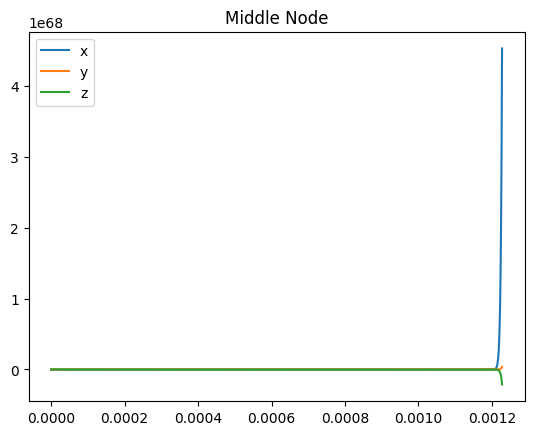

In [25]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

Times = np.linspace(0, len(MSignal), num=len(MSignal)+1)
Times *= ts

for i in range(len(MSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+MSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+MSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+MSignal[i][2] * ts)

plt.clf()
plt.title('Middle Node')
plt.plot(Times,vxDisplacement,label='x')
plt.plot(Times,vyDisplacement,label='y')
plt.plot(Times,vzDisplacement,label='z')
plt.legend()
plt.savefig(imFolder+runName+'DisplaceMid.png')
#plt.show()

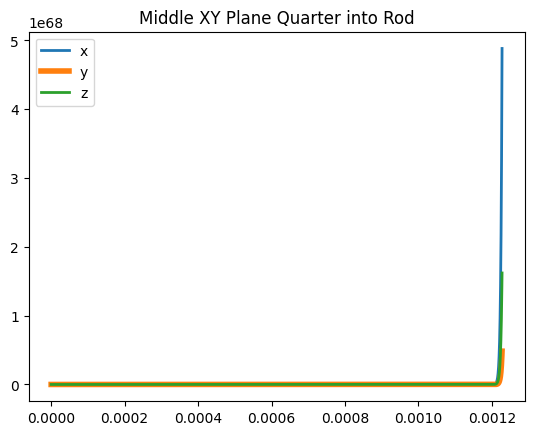

In [26]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(FSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+FSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+FSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+FSignal[i][2] * ts)

plt.clf()
plt.title('Middle XY Plane Quarter into Rod')
plt.plot(Times,vxDisplacement,label='x', linewidth=2)
plt.plot(Times,vyDisplacement,label='y', linewidth=4)
plt.plot(Times,vzDisplacement,label='z', linewidth=2)
plt.legend()
plt.savefig(imFolder+runName+'DisplaceFront.png')
plt.show()

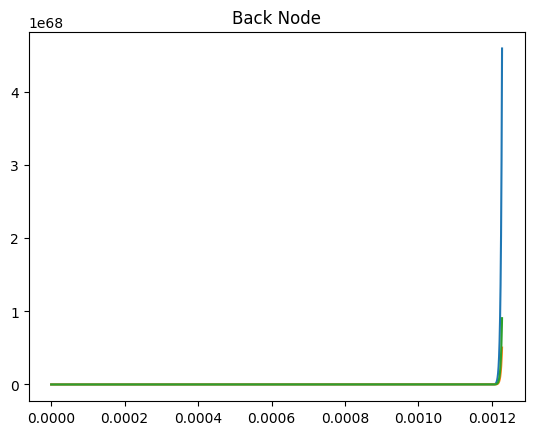

In [27]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(BSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+BSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+BSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+BSignal[i][2] * ts)

plt.clf()
plt.title('Back Node')
plt.plot(Times,vxDisplacement)
plt.plot(Times,vyDisplacement)
plt.plot(Times,vzDisplacement)
plt.savefig(imFolder+runName+'DisplaceBack.png')

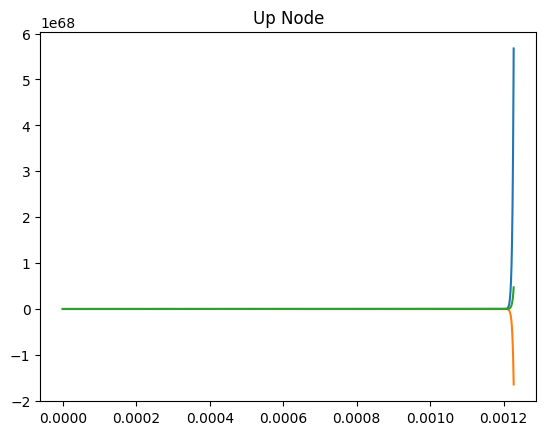

In [28]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(USignal)):
    vxDisplacement.append(vxDisplacement[i-1]+USignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+USignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+USignal[i][2] * ts)

plt.clf()
plt.title('Up Node')
plt.plot(Times,vxDisplacement)
plt.plot(Times,vyDisplacement)
plt.plot(Times,vzDisplacement)
plt.savefig(imFolder+runName+'DisplaceUp.png')

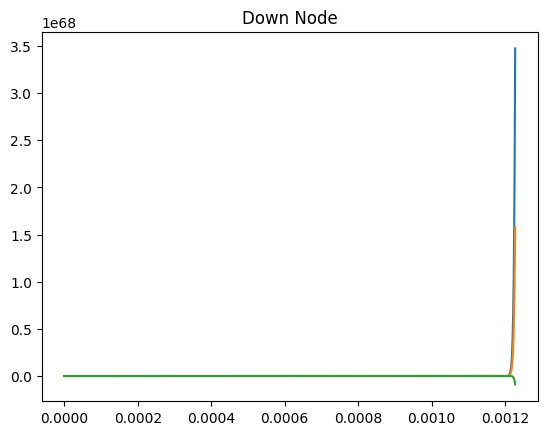

In [29]:
vxDisplacement = [0]
vyDisplacement = [0]
vzDisplacement = [0]

for i in range(len(DSignal)):
    vxDisplacement.append(vxDisplacement[i-1]+DSignal[i][0] * ts)
    vyDisplacement.append(vyDisplacement[i-1]+DSignal[i][1] * ts)
    vzDisplacement.append(vzDisplacement[i-1]+DSignal[i][2] * ts)

plt.clf()
plt.title('Down Node')
plt.plot(Times,vxDisplacement)
plt.plot(Times,vyDisplacement)
plt.plot(Times,vzDisplacement)
plt.savefig(imFolder+runName+'DisplaceDown.png')

In [30]:
MidDisplaceX = np.zeros(np.shape(MidMatrixX))
MidDisplaceY = np.zeros(np.shape(MidMatrixY))
MidDisplaceZ = np.zeros(np.shape(MidMatrixZ))


In [31]:
for i in range(np.shape(MidMatrixX)[0]):
    for j in range(np.shape(MidMatrixX)[1]):
        if j == 0:
            MidDisplaceX[i,j]=MidMatrixX[i,j]*ts
            MidDisplaceY[i,j]=MidMatrixY[i,j]*ts
            MidDisplaceZ[i,j]=MidMatrixZ[i,j]*ts
        else:
            MidDisplaceX[i,j]=MidDisplaceX[i,j-1]+MidMatrixX[i,j]*ts
            MidDisplaceY[i,j]=MidDisplaceY[i,j-1]+MidMatrixY[i,j]*ts
            MidDisplaceZ[i,j]=MidDisplaceZ[i,j-1]+MidMatrixZ[i,j]*ts
            

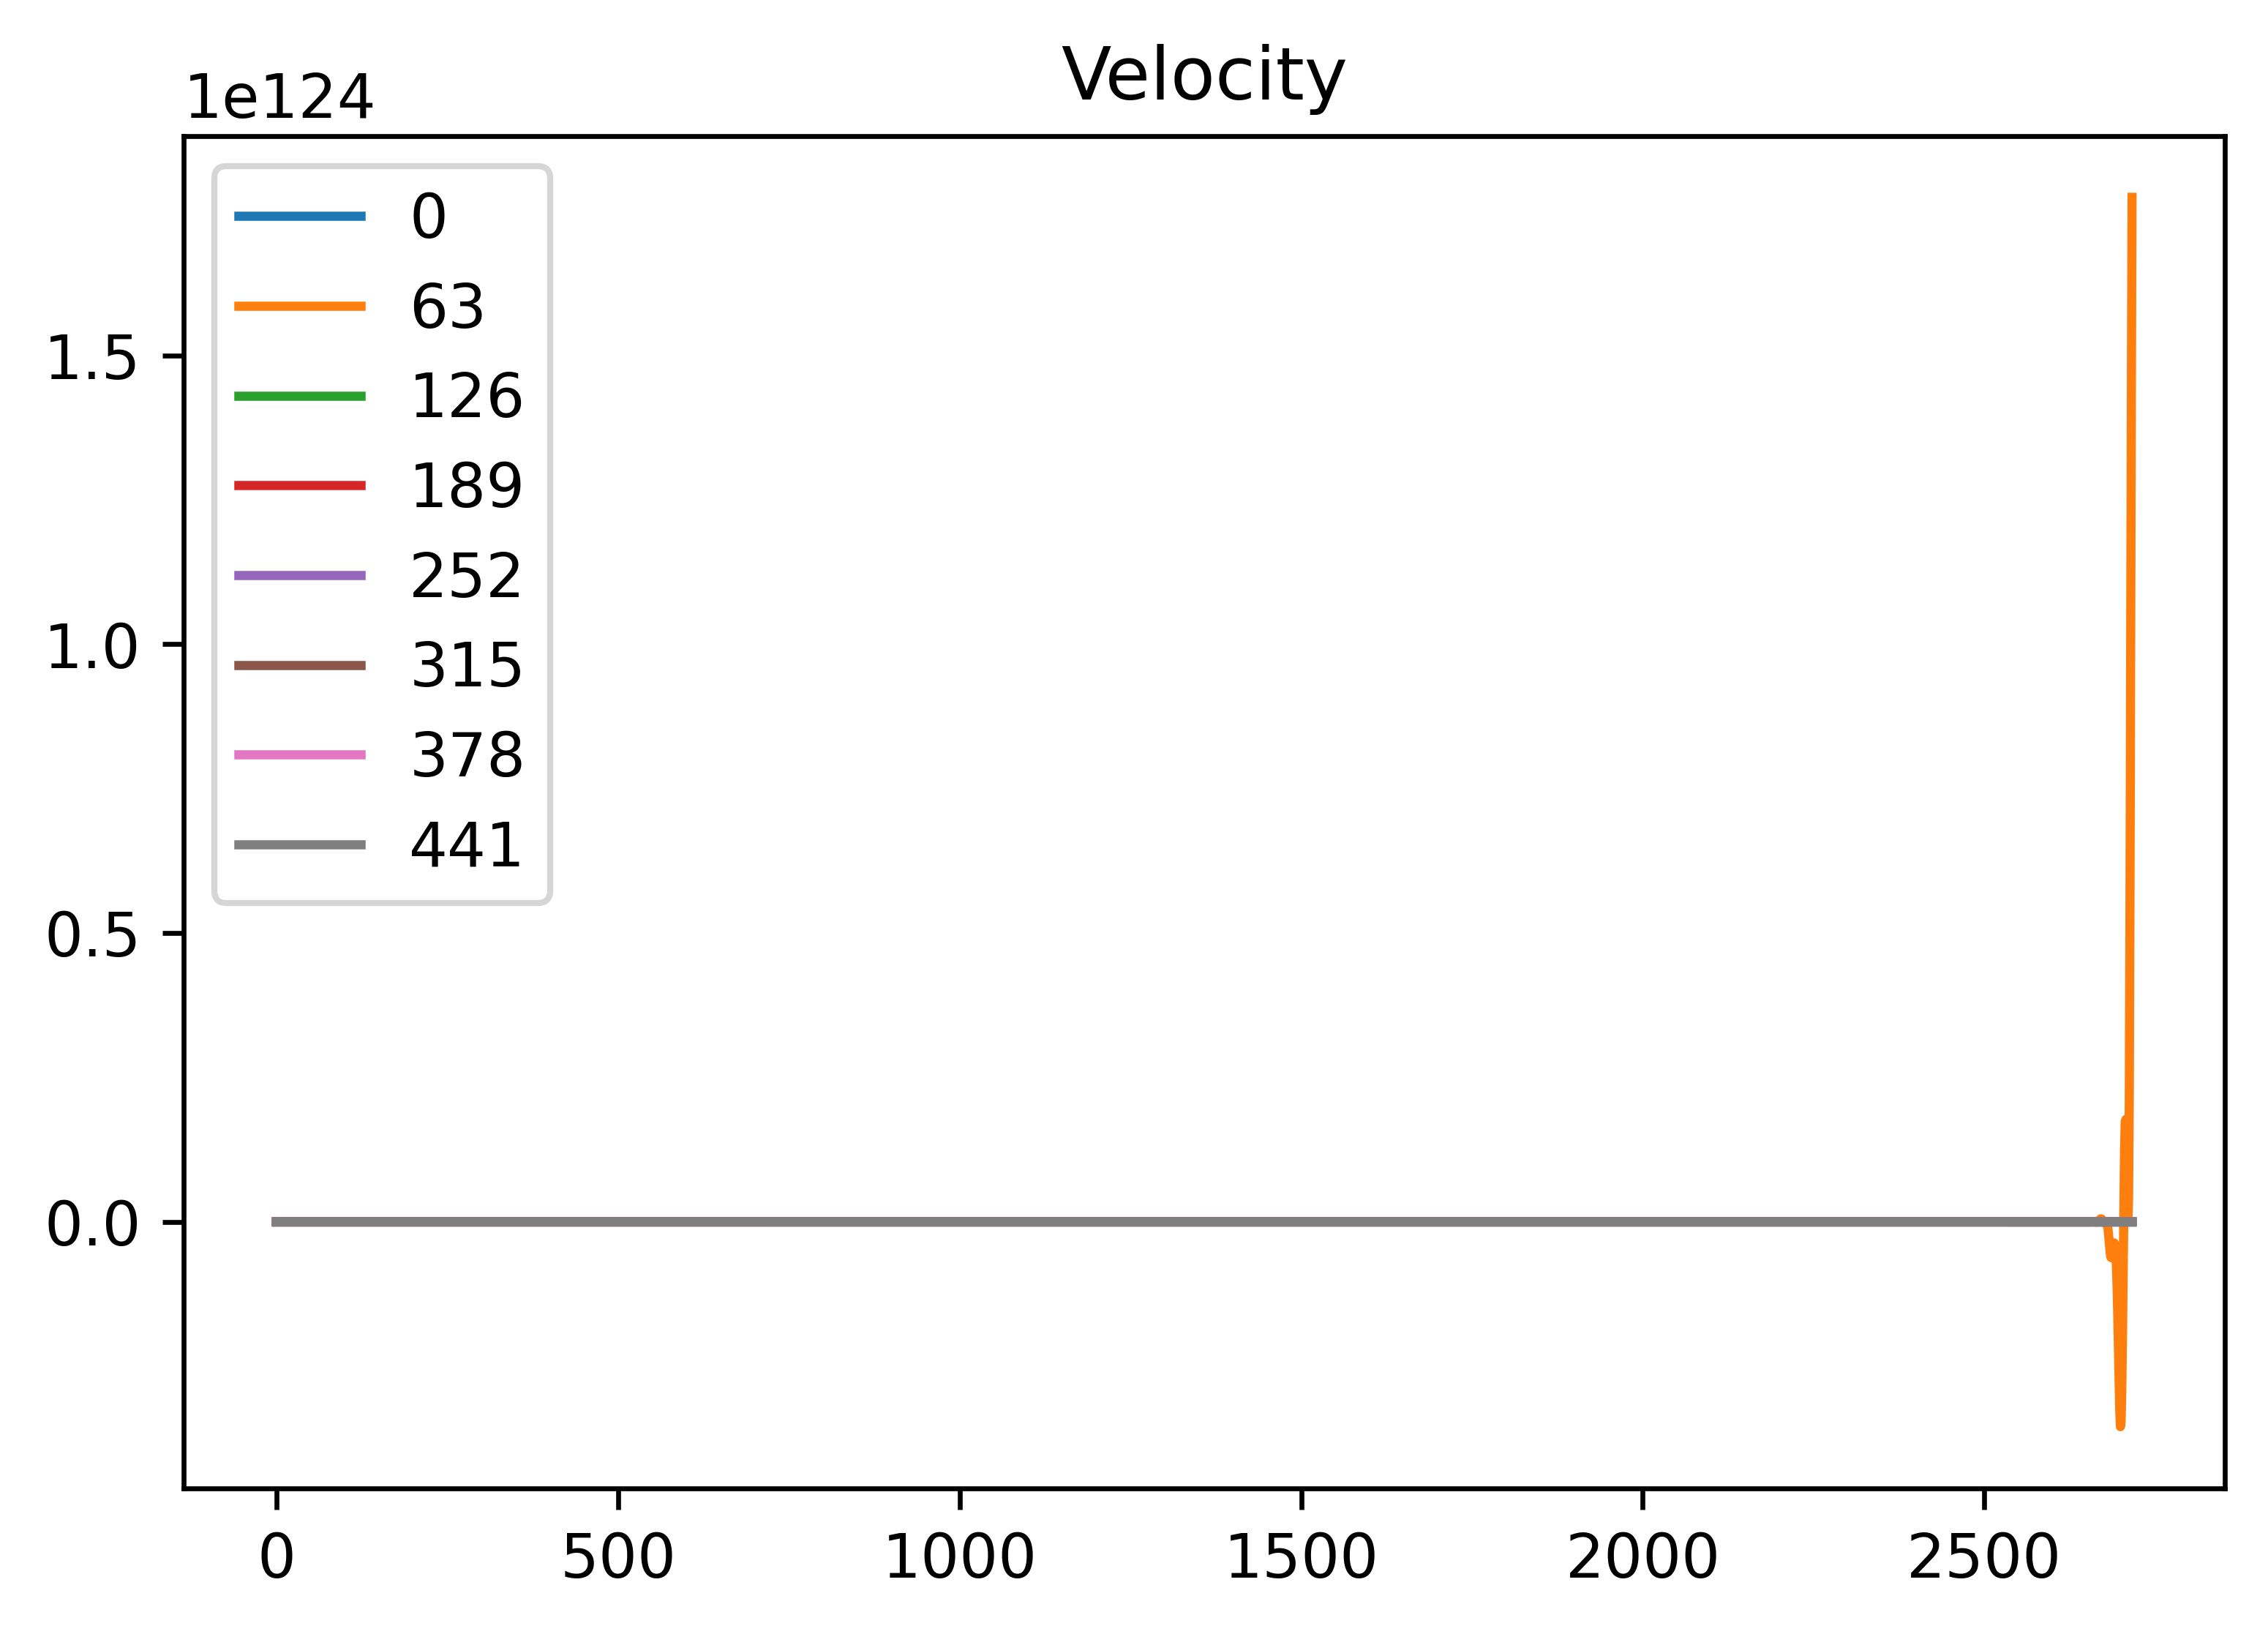

In [32]:
pts = 8
rng = int(gl1/pts)-1

fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidMatrixX[i*rng,:],label=str(i*rng))
plt.title('Velocity')
plt.legend()
plt.savefig(imFolder+runName+'MidVelocities.png')
plt.show()

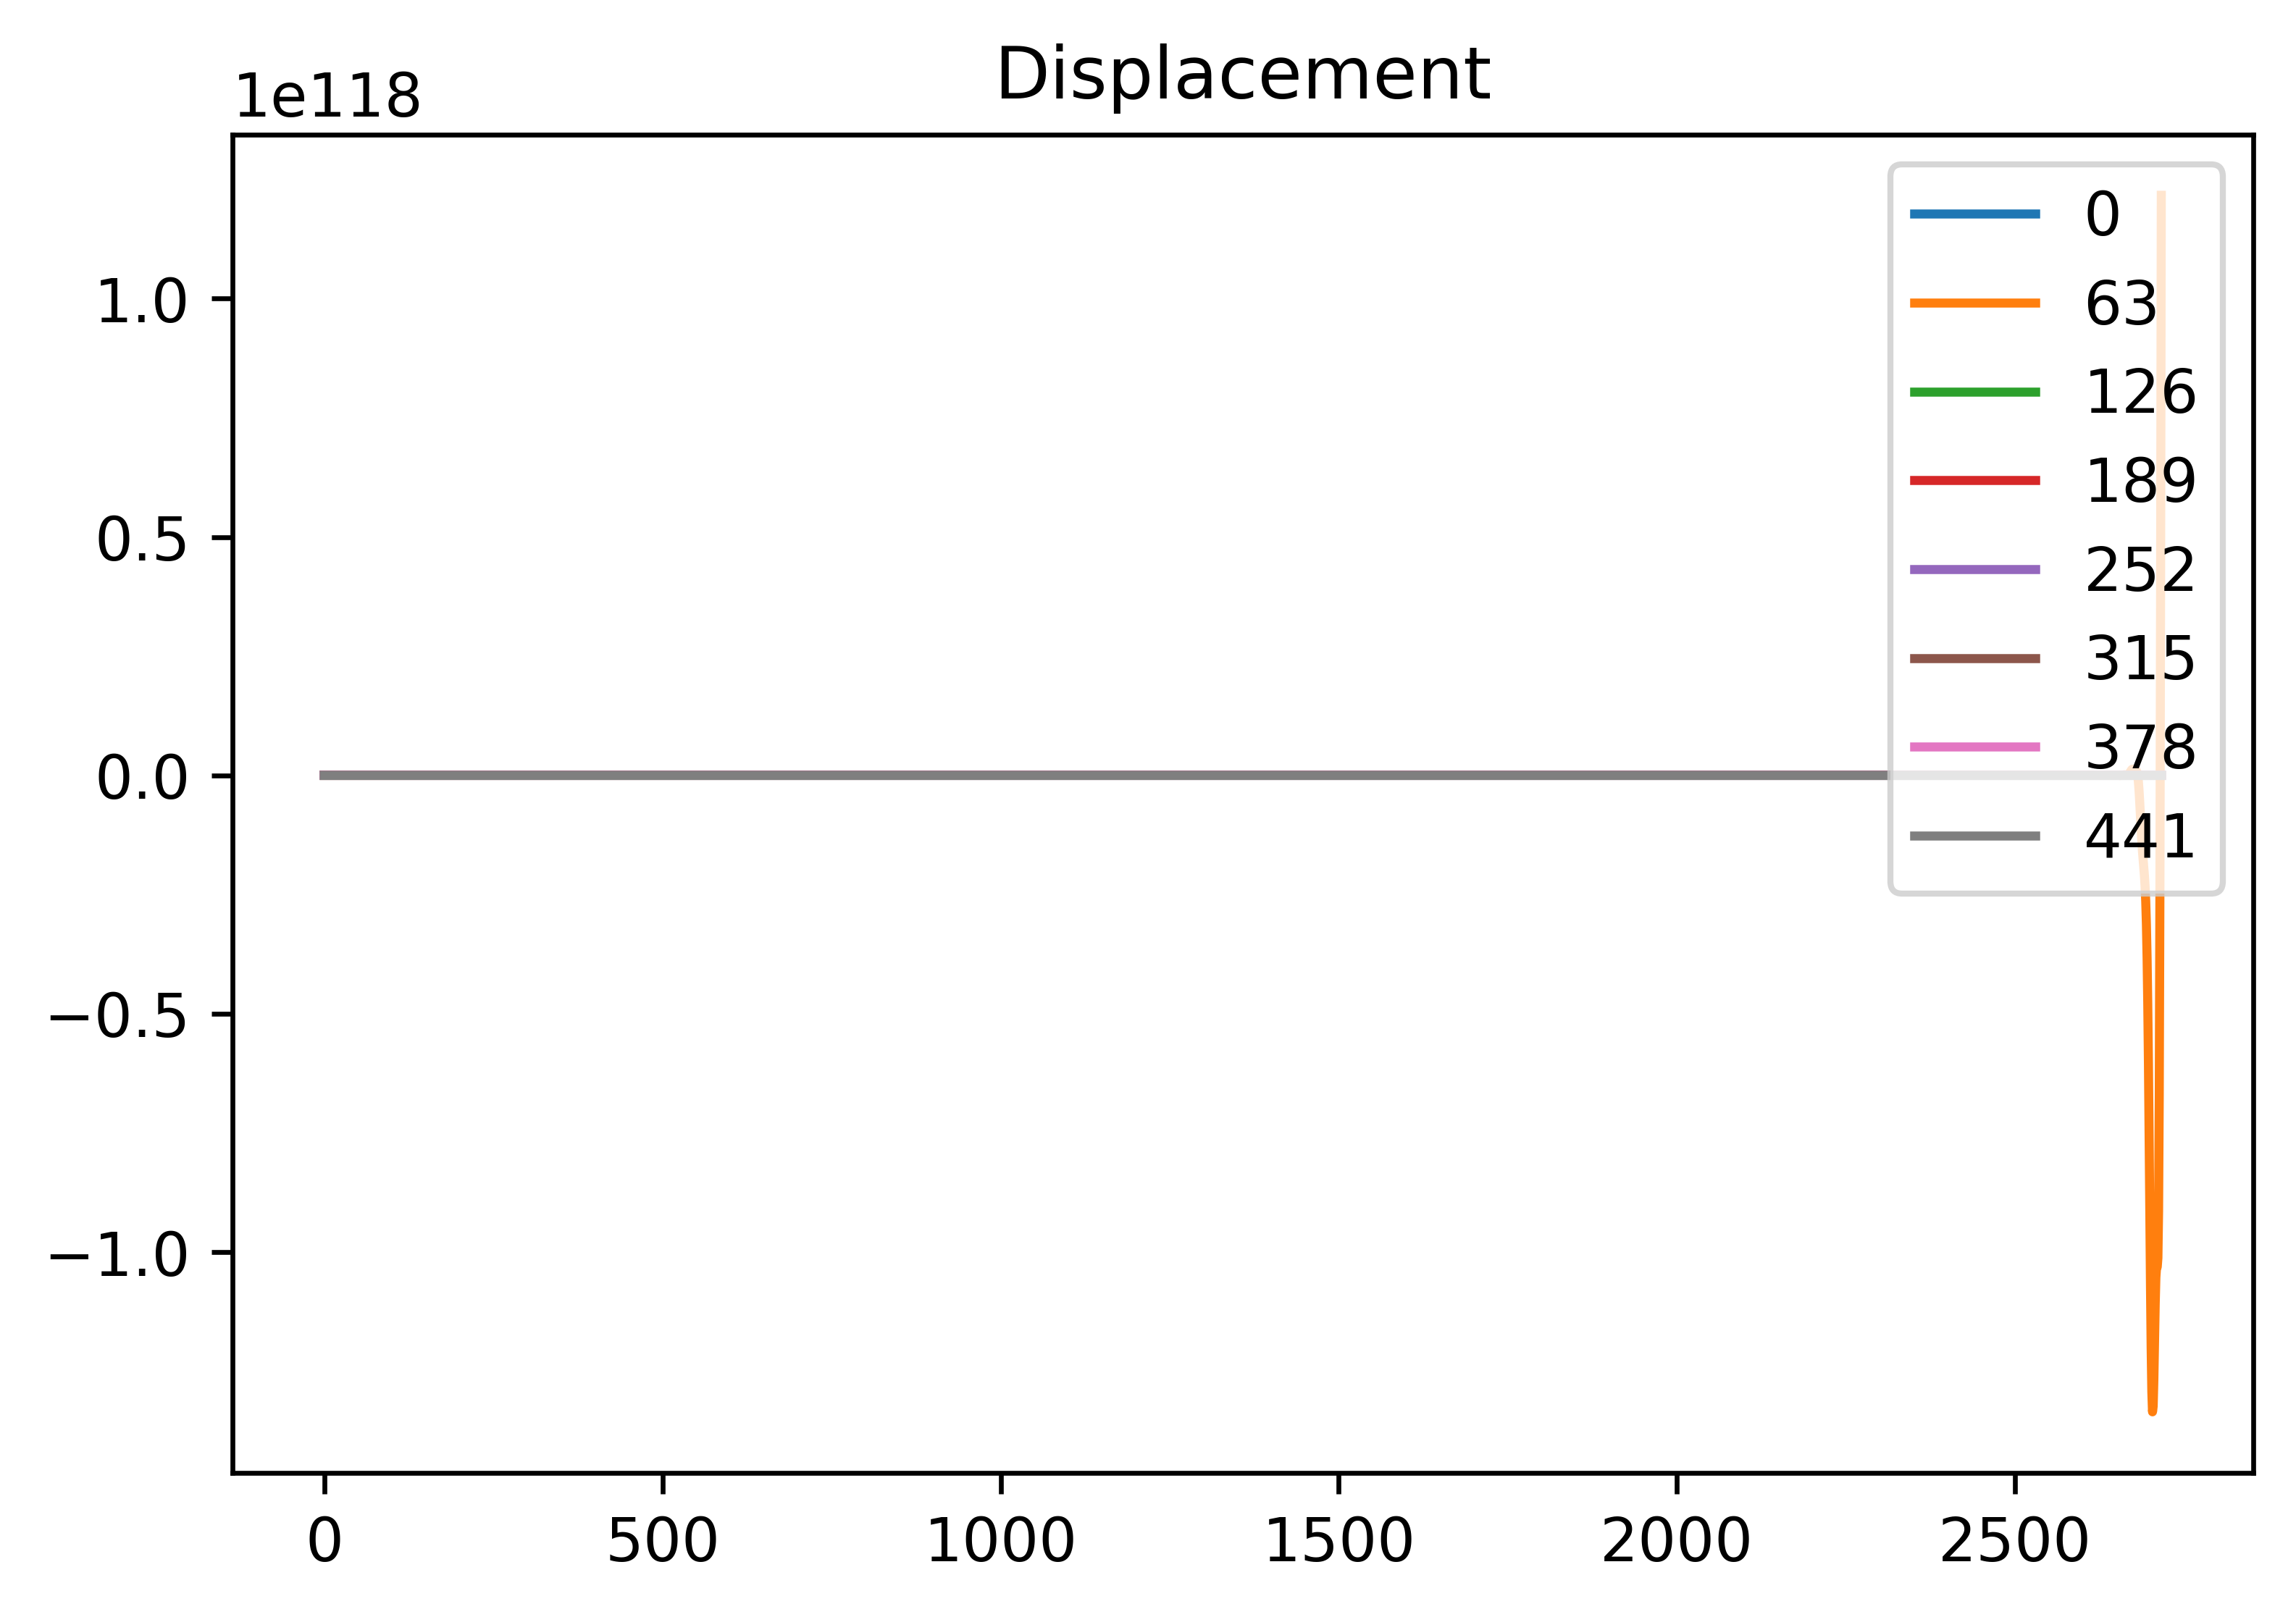

In [33]:
fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidDisplaceX[i*rng,:],label=str(i*rng))
plt.legend()
plt.title('Displacement')
plt.savefig(imFolder+runName+'MidDisplacementsX.png')
plt.show()

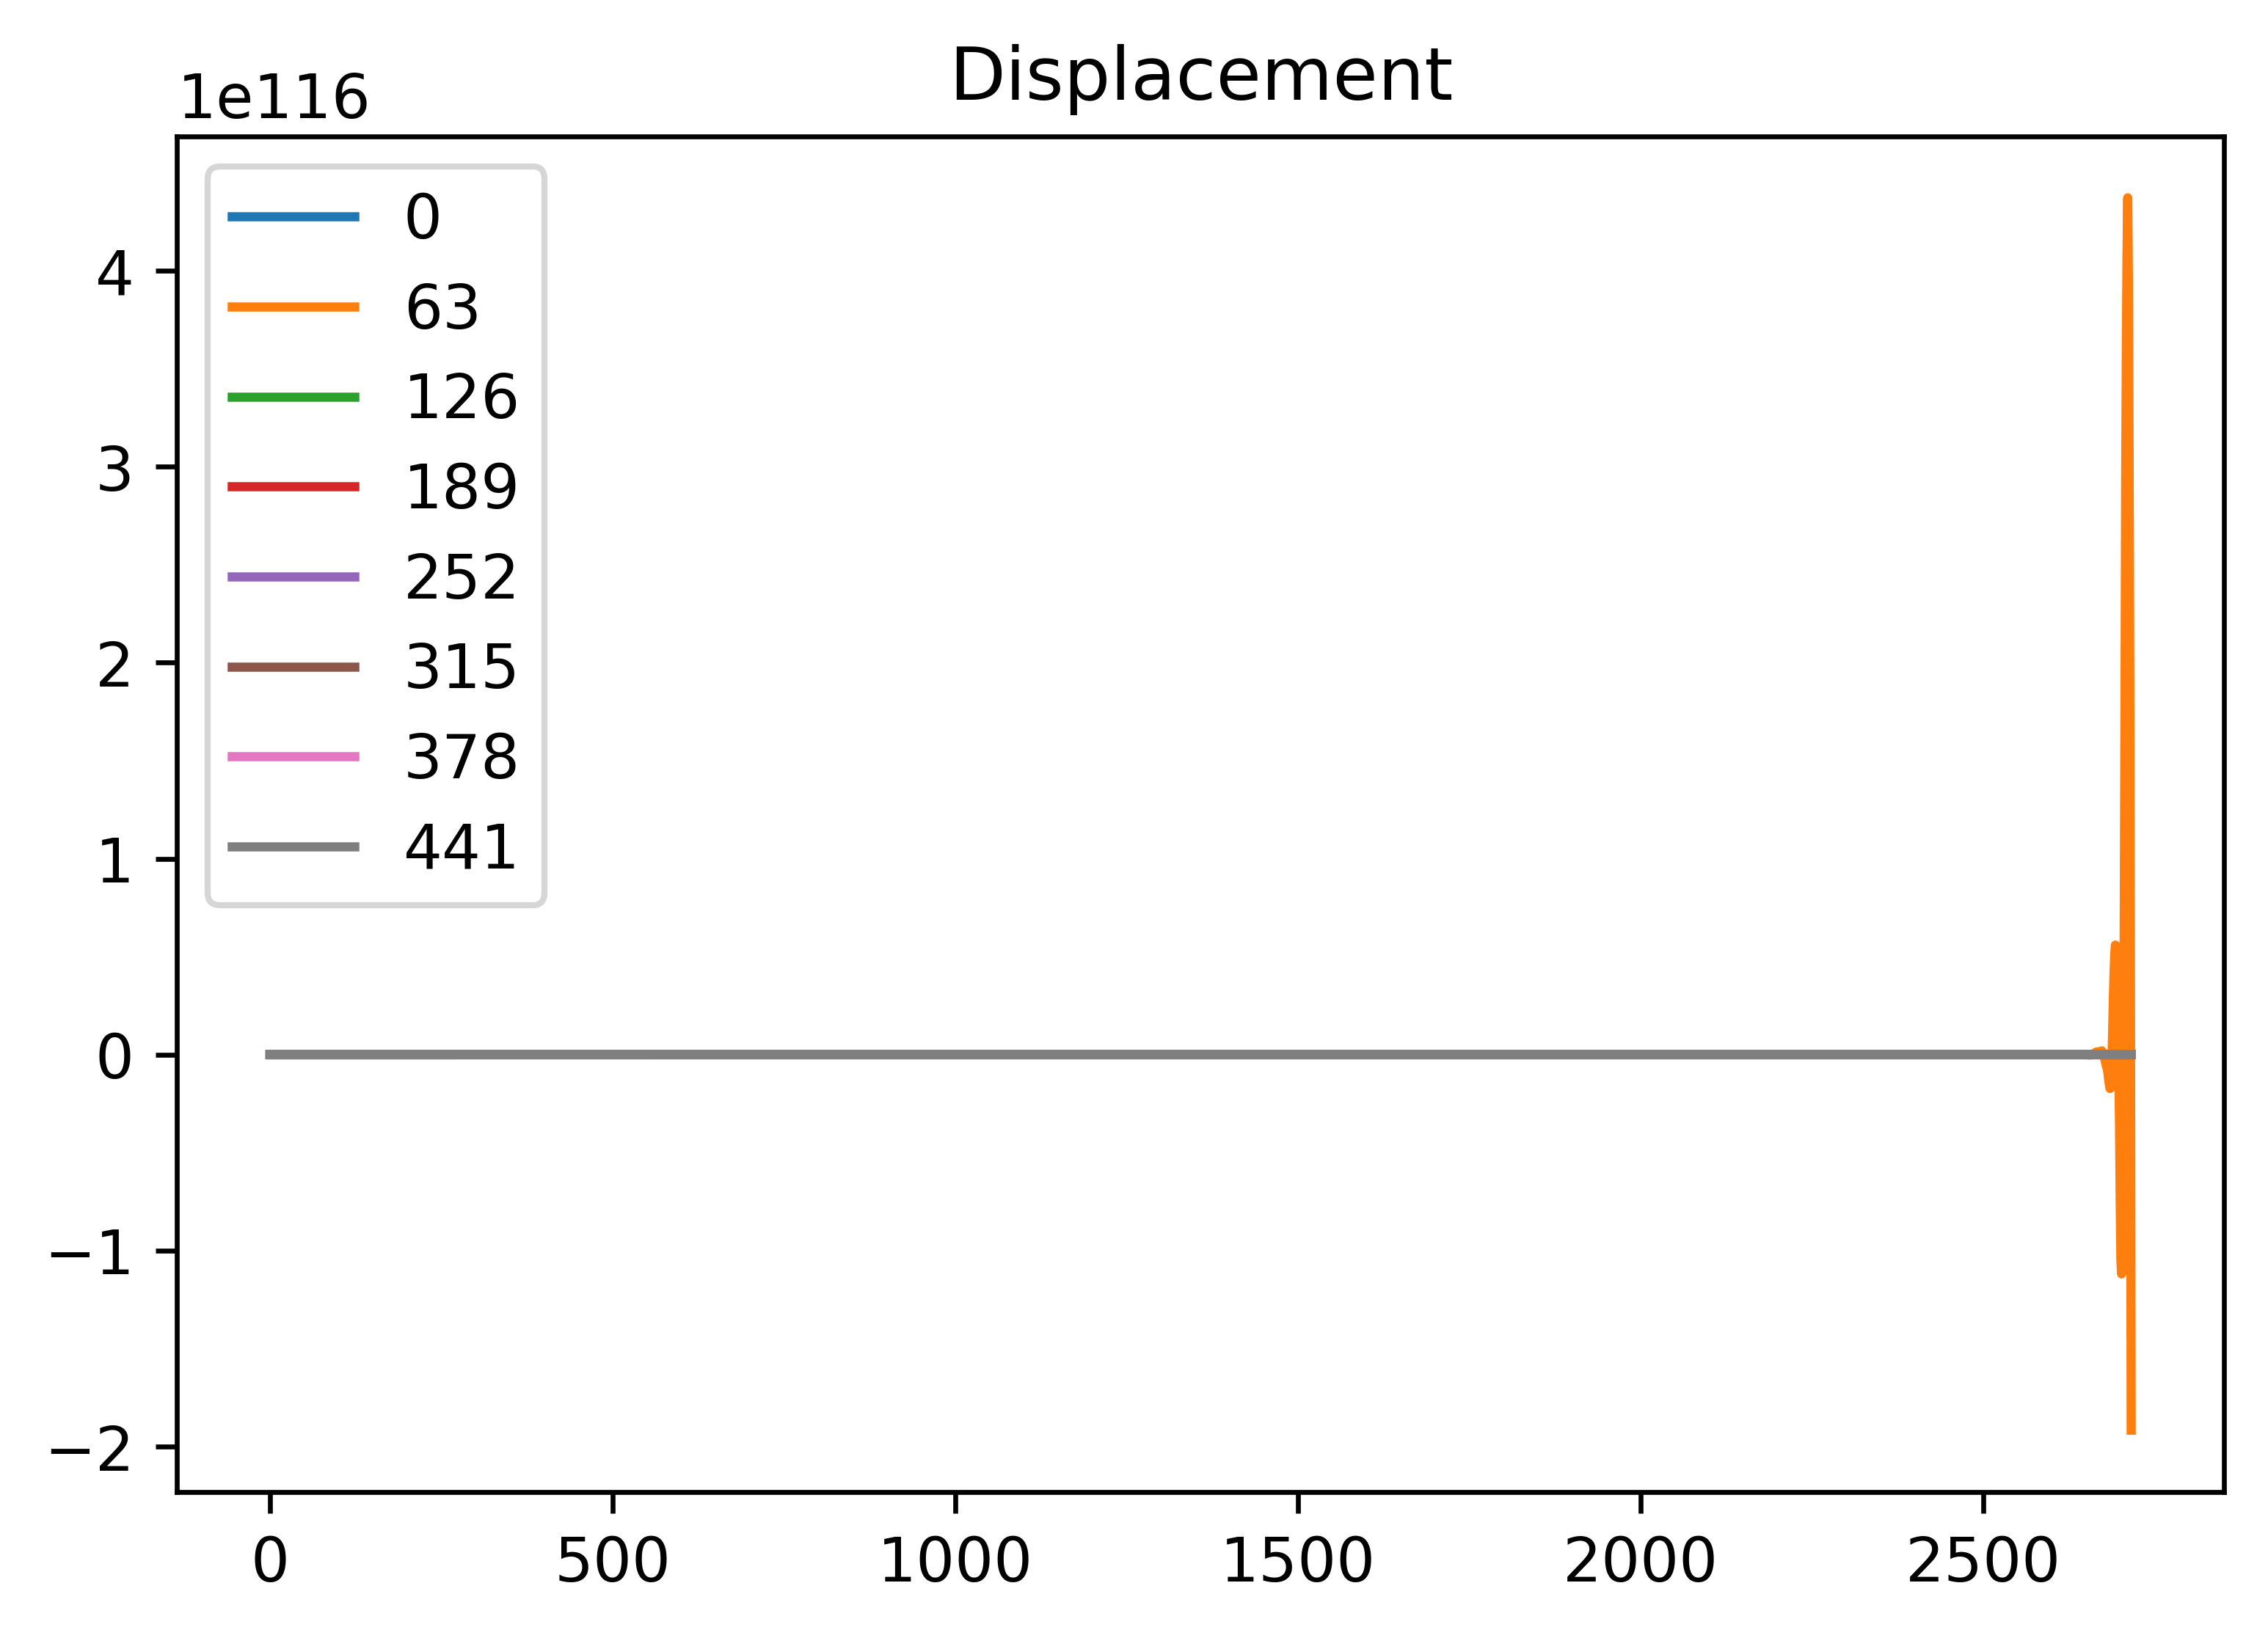

In [34]:
fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidDisplaceY[i*rng,:],label=str(i*rng))
plt.legend()
plt.title('Displacement')
plt.savefig(imFolder+runName+'MidDisplacementsY.png')
plt.show()

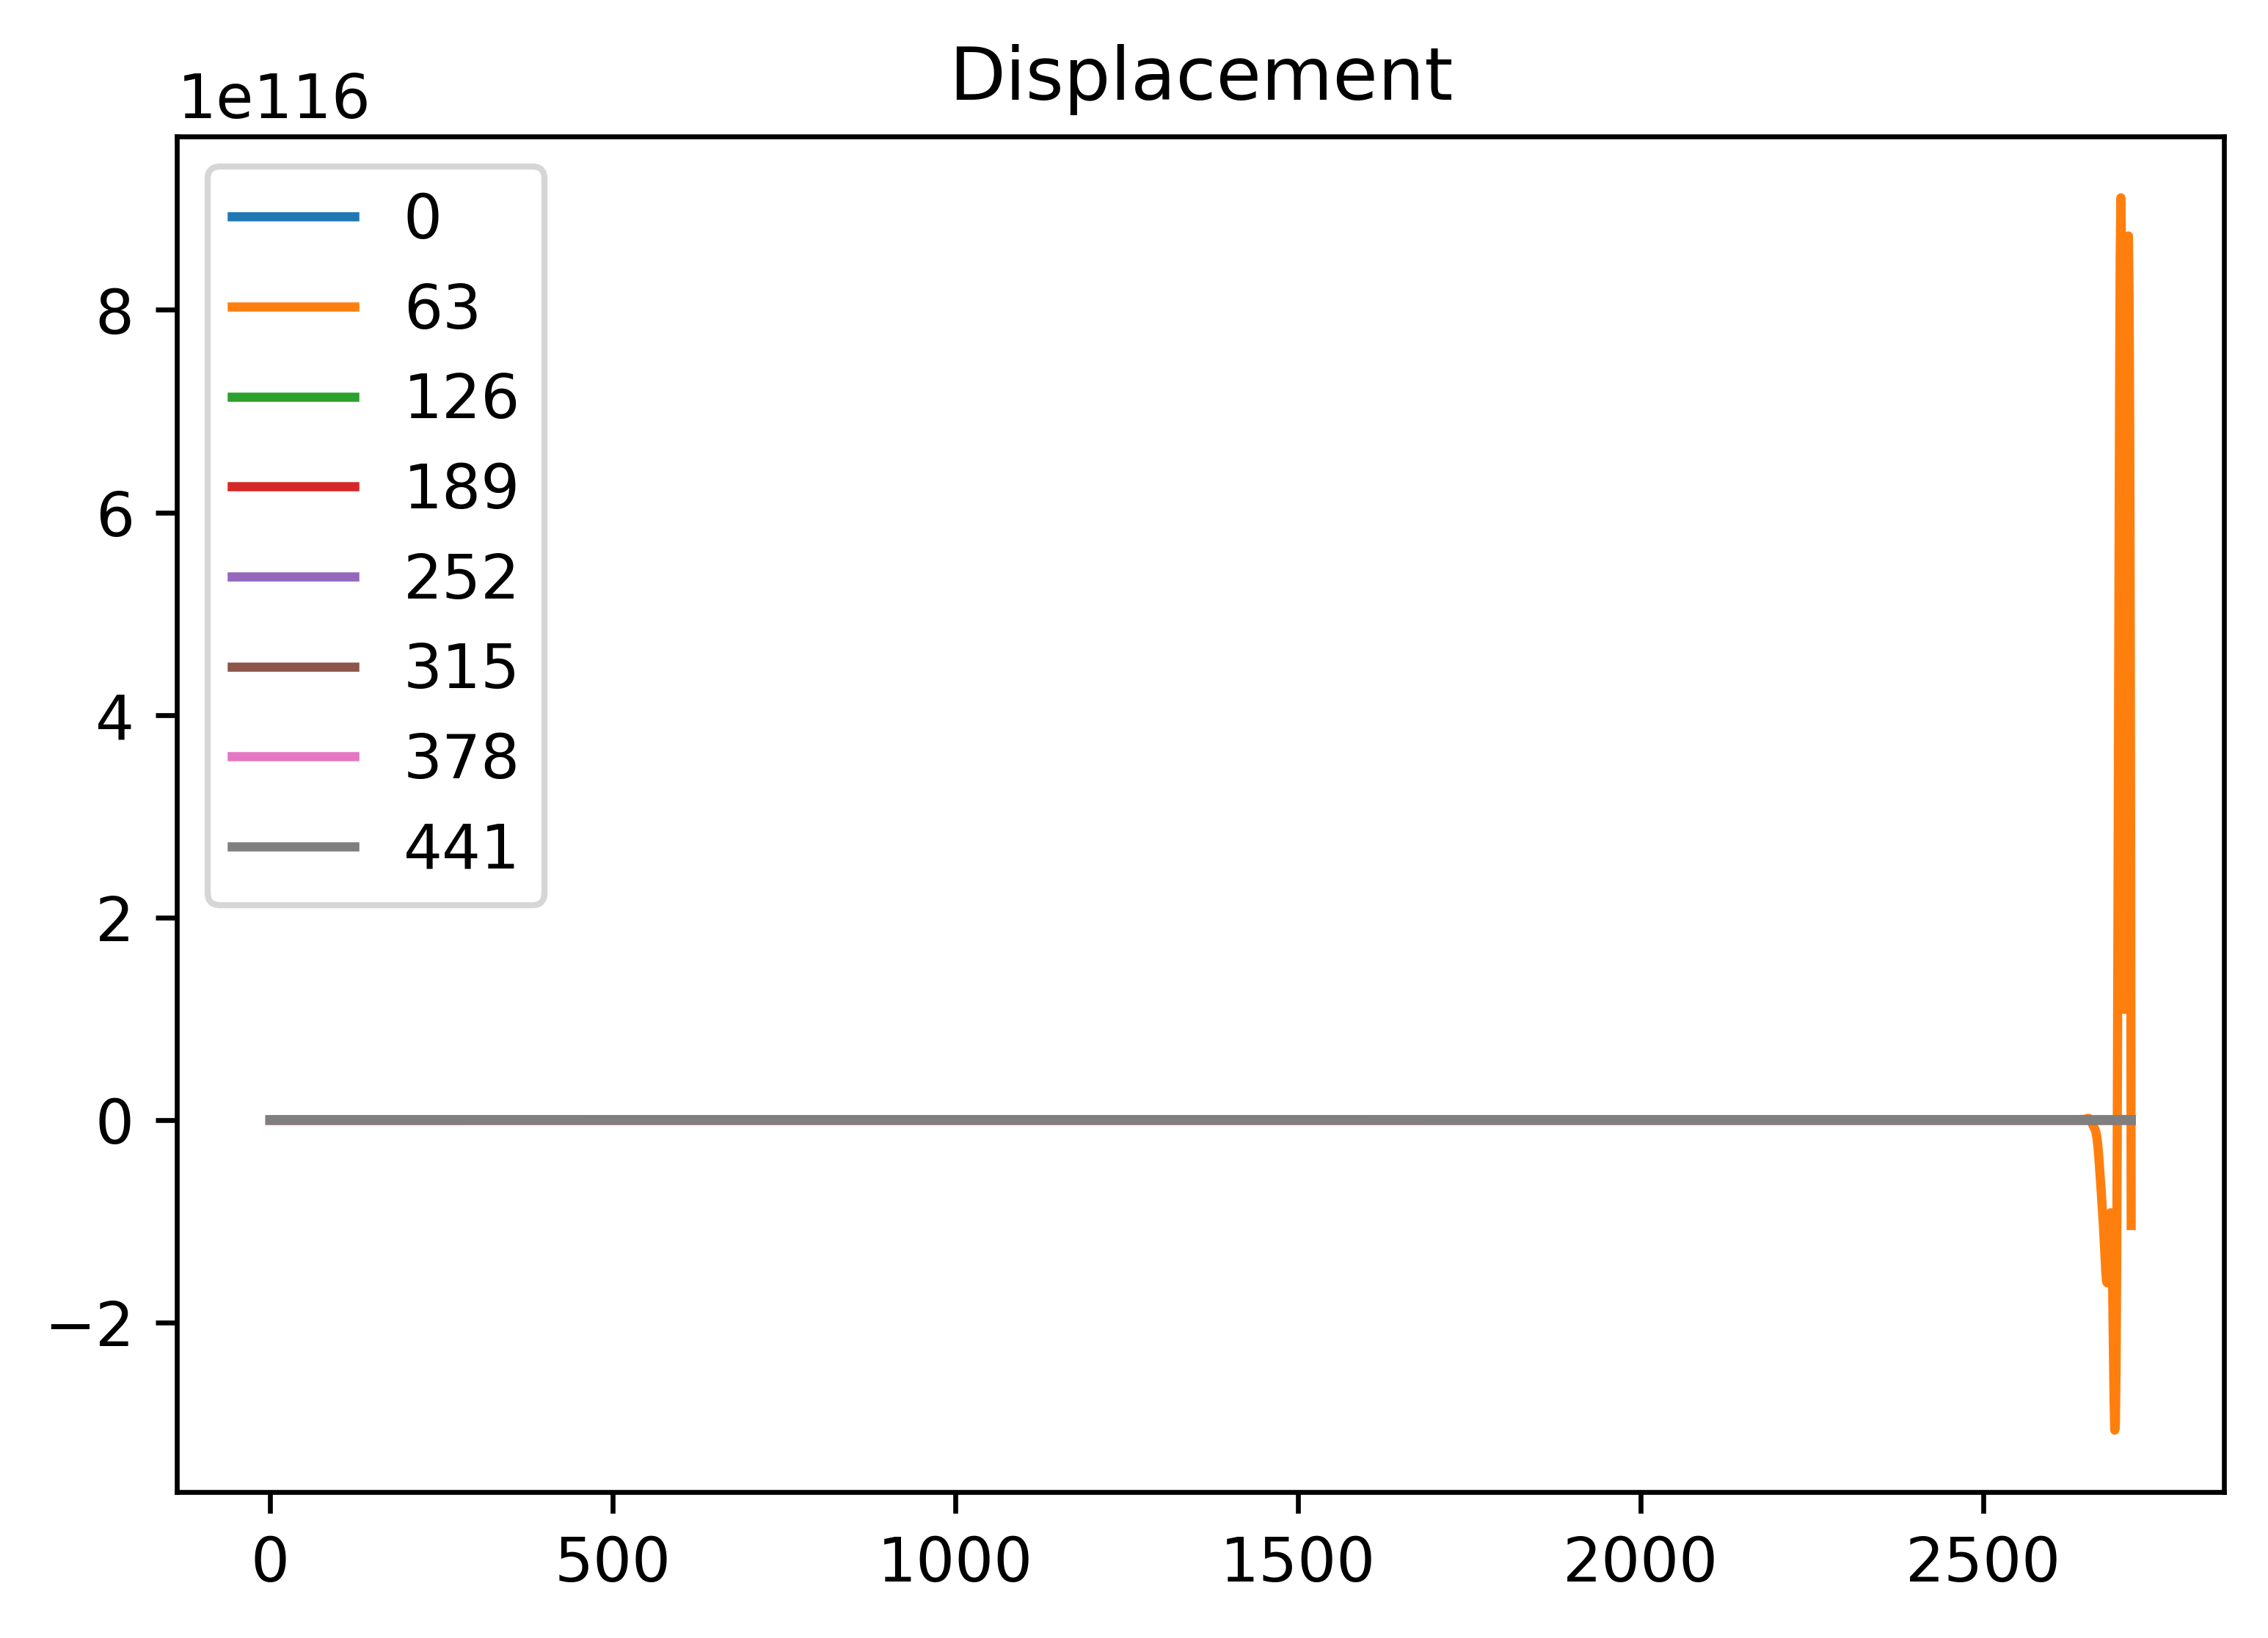

In [35]:
fig = plt.figure(dpi=600, figsize=(6,4))
for i in range(pts):
    plt.plot(MidDisplaceZ[i*rng,:],label=str(i*rng))
plt.legend()
plt.title('Displacement')
plt.savefig(imFolder+runName+'MidDisplacementsZ.png')
plt.show()

In [36]:
import multiprocessing
from joblib import Parallel, delayed
num_jobs=19

In [37]:
def EnergyFig(t, xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder, v, figH):
    
    fig = plt.figure(figsize=(6,figH), dpi=300)
    
    Image = Movements[xStart:xEnd, yStart:yEnd, zStart:zEnd,t].T
    
    x,y,z = np.shape(Image)
    if x ==1:
        I2 = np.squeeze(Image, axis=(0,))
    if y ==1:
        I2 = np.squeeze(Image, axis=(1,))
    if z ==1:
        I2 = np.squeeze(Image, axis=(2,))
    
    plt.contourf(I2, v, cmap=plt.cm.jet)
    plt.savefig(imFolder+Folder+'/Energy'+str(t).zfill(5)+'.png')
    plt.close(fig)

In [38]:
def AnimationBook(xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder):

    if xStart - xEnd == 0.0:
        figH = 6 * (yEnd - yStart) / (zEnd-zStart)
        xEnd+=1
    elif yStart - yEnd == 0.0:
        figH = 6 * (zEnd - zStart) / (xEnd-xStart)
        yEnd+=1
    elif zStart - zEnd == 0.0:
        figH = 6 * (yEnd - yStart) / (xEnd-xStart)
        zEnd+=1
    else:
        figH = 0

    if figH==0:
        print("Error, no Dimmension is a plane",yStart-yEnd)
    else:
        EMin = np.min(Movements[xStart:xEnd, yStart:yEnd, zStart:zEnd,:])
        EMax = np.max(Movements[xStart:xEnd, yStart:yEnd, zStart:zEnd,:])
        v = np.linspace(EMin, EMax, 30, endpoint=True)[0:20]

        temp = Parallel(n_jobs=num_jobs)(delayed(EnergyFig)(t, xStart, xEnd, yStart, yEnd, zStart, zEnd, Folder,v,figH) for t in range(Tsteps))


In [39]:
plt.close('all')
AnimationBook(0,xmax,gridEndWeb-1,gridEndWeb-1,gridEndFoot,gridStartHead,"WebEnd")
plt.close('all')
AnimationBook(0,xmax,gridEndHeadWidth-1,gridEndHeadWidth-1,gridStartHead,zmax,"HeadEnd")
plt.close('all')
AnimationBook(0,xmax,gridStartHeadWidth,gridEndHeadWidth,zmax-3,zmax-3,"TopSurface")
plt.close('all')
AnimationBook(0,xmax,gridStartHeadWidth,gridStartHeadWidth,gridStartHead,zmax,"LeftSurface")
plt.close('all')
AnimationBook(0,xmax,gridStartWeb,gridStartWeb,gridEndFoot,gridStartHead,"RightSurface")
plt.close('all')


In [40]:
import glob
import os as os

In [41]:
import keras.utils as image

2023-10-06 02:18:33.093620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
Views = ['Mid', 'Vert','Head','zplane25','zplane75','TopSurface','Energy','LeftSurface','RightSurface','TopEnergy','HeadEnd','WebEnd']


In [43]:
imFolder

'/sciclone/scr10/dchendrickson01/EFIT/AbsorbTest/'

In [44]:
for View in Views:
    imfolder = imFolder + View+'/'
    files = glob.glob(os.path.join(imfolder, '*.png'))
    print(View, len(files))
    files.sort()
    images = []

    for file in files:
        images.append(image.load_img(file))
    try:
        images[0].save(imFolder + 'Testing'+View+'.gif',
           save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)
    except:
        pass

Mid 544
Vert 544
Head 544
zplane25 544
zplane75 544
TopSurface 3261
Energy 0
LeftSurface 3261
RightSurface 3261
TopEnergy 0
HeadEnd 2717
WebEnd 2717


In [45]:
SaveData = np.concatenate((FSignal,BSignal), axis = 1)

In [46]:
SaveData = np.concatenate((SaveData,USignal), axis =1)
SaveData = np.concatenate((SaveData,DSignal), axis =1)
SaveData = np.concatenate((SaveData,RSignal), axis =1)
SaveData = np.concatenate((SaveData,LSignal), axis =1)
SaveData = np.concatenate((SaveData,MSignal), axis =1)



In [47]:
np.shape(SaveData)

(2717, 21)

In [49]:
SaveData = np.asarray(SaveData).reshape(2717,21)

In [50]:
np.savetxt(runName+'LaserPoints2.csv',SaveData,delimiter=", ")

In [ ]:
import CoreFunctions as cf